This notebook is looking at the original data for the Intercloud Region 

In [97]:
###Import the usual libraries and data
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24}) #make plots more readable

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack #, MaskedColumn
from astropy import units as u
from astropy.coordinates import SkyCoord

from scipy.stats import kurtosis, skew, iqr

#import csv

In [94]:
###Code to Convert to MS coordinates
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

class MagellanicStream(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the Magellanic Stream
    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    MSLongitude : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to the Magellanic Stream.
    MSLatitude : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to the Magellanic Stream.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the Stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.
    """
    default_representation = coord.SphericalRepresentation
    #default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'MSLongitude'),
            coord.RepresentationMapping('lat', 'MSLatitude'),
            coord.RepresentationMapping('distance', 'distance')]#,
        #coord.SphericalCosLatDifferential: [
        #    coord.RepresentationMapping('d_lon_coslat', 'pm_lon_coslat'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #    coord.RepresentationMapping('d_distance', 'radial_velocity')],
        #coord.SphericalDifferential: [
        #    coord.RepresentationMapping('d_lon', 'pm_lon'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #   coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    #frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
    #    frame_specific_representation_info[coord.SphericalCosLatDifferential]
    #frame_specific_representation_info[coord.UnitSphericalDifferential] = \
    #    frame_specific_representation_info[coord.SphericalDifferential]


MS_PHI = (180 + 8.5 + 90) * u.degree # Euler angles (from Nidever 2010)
MS_THETA = (90 + 7.5) * u.degree
MS_PSI = -32.724214217871349 * u.degree  # anode parameter from gal2mag.pro

D = rotation_matrix(MS_PHI, "z")
C = rotation_matrix(MS_THETA, "x")
B = rotation_matrix(MS_PSI, "z")
A = np.diag([1., 1., 1.])
MS_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, MagellanicStream)
def galactic_to_MS():
    """ Compute the transformation matrix from Galactic spherical to
        Magellanic Stream coordinates.
    """
    return MS_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, MagellanicStream, coord.Galactic)
def MS_to_galactic():
    """ Compute the transformation matrix from Magellanic Stream coordinates to
        spherical Galactic.
    """
    return matrix_transpose(MS_MATRIX)

###Actual coordinate transform from previous cell
#c_icrs = SkyCoord(ra=tmp.ra.data*u.degree, dec=tmp.dec.data*u.degree)
#c_ms = c_icrs.transform_to(MagellanicStream)
#ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

In [17]:
###Import data
filepath1 = '/Users/joshpovick/Desktop/Research/fits/final_dupont_oct09.fits' #second icr fits file
filepath2 = '/Users/joshpovick/Desktop/Research/fits/dupont7.fits' #7 as xmatched gaia data for final_dupont_oct09
filepath3 = '/Users/joshpovick/Desktop/Research/fits/bstars.fits' #original icr stars fits
filepath4 = '/Users/joshpovick/Desktop/Research/fits/gaia6as.fits' #6 as xmatched with bstars

dupont = fits.getdata(filepath1,1)
gaiadupont = fits.getdata(filepath2,1) #contains dupont, columns not labelled for that part
icrstar = fits.getdata(filepath3,1)
gaiaicr = fits.getdata(filepath4,1) #contains icrstar, columns not labelled for that part

In [87]:
###Create a master fits file that inlcudes all the imported data

#Put gaiadupont into a table and add dupont column names to respective columns
tgaiadupont = Table(gaiadupont)

tgaiadupont['col1'].name = 'NAME'
tgaiadupont['col2'].name = 'FILE'
tgaiadupont['col3'].name = 'MEDCOUNT'
tgaiadupont['col4'].name = 'SNR'
tgaiadupont['col5'].name = 'RA'
tgaiadupont['col6'].name = 'DEC'
tgaiadupont['col7'].name = 'GLON'
tgaiadupont['col8'].name = 'GLAT'    
tgaiadupont['col9'].name = 'MLON'
tgaiadupont['col10'].name = 'MLAT'
tgaiadupont['col11'].name = 'VHELIO'
tgaiadupont['col12'].name = 'VLSR'
tgaiadupont['col13'].name = 'VGSR'
tgaiadupont['col14'].name = 'STDEV'
tgaiadupont['col15'].name = 'VERR'
tgaiadupont['col16'].name = 'V' 
tgaiadupont['col17'].name = 'BV'
tgaiadupont['gaia_rad_xmatch'] = 7.0 #add in column for xmatch radius in units of as

#Put gaiaicr into a table and add icrstar column names to respective columns
#Create table of the xmatch data from icr and rename columns
tgaiaicr = Table(gaiaicr)

tgaiaicr['col1'].name = 'NAME'
tgaiaicr['col2'].name = 'RA'
tgaiaicr['col3'].name = 'DEC'
tgaiaicr['col4'].name = 'GLON'
tgaiaicr['col5'].name = 'GLAT'
tgaiaicr['col6'].name = 'MLON'
tgaiaicr['col7'].name = 'MLAT'
tgaiaicr['col8'].name = 'V'
tgaiaicr['col9'].name = 'BV'
tgaiaicr['col10'].name = 'EBV'
tgaiaicr['col11'].name = 'VHELIO_SMARTS'
tgaiaicr['col12'].name = 'VERR_SMARTS'
tgaiaicr['col13'].name = 'VHELIO_MIKE'
tgaiaicr['col14'].name = 'VERR_MIKE'
tgaiaicr['col15'].name = 'VHELIO'
tgaiaicr['col16'].name = 'VERR'
tgaiaicr['col17'].name = 'VELTYPE'
tgaiaicr['col18'].name = 'VLSR'
tgaiaicr['col19'].name = 'VGSR'
tgaiaicr['col20'].name = 'LMCVLOS'
tgaiaicr['col21'].name = 'TEFF'
tgaiaicr['col22'].name = 'TEFFERR'
tgaiaicr['col23'].name = 'LOGG'
tgaiaicr['col24'].name = 'LOGGERR'
tgaiaicr['col25'].name = 'METAL'
tgaiaicr['col26'].name = 'METALERR'
tgaiaicr['col27'].name = 'VSINI'
tgaiaicr['col28'].name = 'VSINIERR'
tgaiaicr['gaia_rad_xmatch'] = 6.0 #add in column for xmatch radius in units of as

#create the master fits file
master=vstack([tgaiadupont,tgaiaicr])
#master.write('/Users/joshpovick/Desktop/Research/fits/intercloudmaster.fits',format='fits') #error file exists
master.show_in_browser(jsviewer=True)

In [91]:
###Find and rid the data of duplicates 

#Find duplicates in the xmatched data for dupont xmatch
nom = np.append(dupont['NAME'],icrstar['NAME'])
idx = []
for i0 in range(len(dupont['NAME'])+len(icrstar['NAME'])):
    a = [i1 for i1,x in enumerate(master['NAME']) if x == nom[i0]]
    idx.append(a)

b = [i2 for i2, y in enumerate(idx) if len(idx[i2])>1]

print(master['dist'][6],'1st set 6')
print(master['dist'][7],'1st set 7')
print(master['dist'][10],'2nd set 10')
print(master['dist'][11],'2nd set 11')
print(master['dist'][19],'3rd set 19')
print(master['dist'][72],'3rd set 72')
print(master['dist'][25],'4th set 25')
print(master['dist'][110],'4th set 110')
print(master['dist'][30],'5th set 30')
print(master['dist'][31],'5th set 31')
print(master['dist'][34],'6th set 34')
print(master['dist'][112],'6th set 112')
print(master['dist'][38],'7th set 38')
print(master['dist'][39],'7th set 39')
print(master['dist'][41],'8th set 41')
print(master['dist'][97],'8th set 97')
print(master['dist'][61],'9th set 61')
print(master['dist'][62],'9th set 62')
print(master['dist'][63],'9th set 63')
print(master['dist'][78],'10th set 78')
print(master['dist'][79],'10th set 79')
print(master['dist'][91],'11th set 91')
print(master['dist'][92],'11th set 92')
print(master['dist'][93],'11th set 93')
print(master['dist'][94],'11th set 94')
print(master['dist'][101],'12th set 101')
print(master['dist'][102],'12th set 102')
print(master['dist'][103],'13th set 103')
print(master['dist'][104],'13th set 104')
print(master['dist'][107],'14th set 107')
print(master['dist'][108],'14th set 108')

keepidx = np.arange(0,113,1)
keepidx = np.delete(keepidx,[6,11,19,25,30,39,41,61,62,79,91,93,94,102,103,107,112])

0.0013329404313994523 1st set 6
0.001069520681831953 1st set 7
0.0013427844186541524 2nd set 10
0.001876164058679628 2nd set 11
0.0016100872359973587 3rd set 19
0.0014909744298278625 3rd set 72
0.00038846111968870604 4th set 25
0.00029190641154205844 4th set 110
0.0013850130816626253 5th set 30
0.0002932646947508425 5th set 31
0.00010669952672153618 6th set 34
0.00017279495968089154 6th set 112
0.00021683046425657182 7th set 38
0.00028291425940975344 7th set 39
0.00019655193732498577 8th set 41
0.00012332004922331952 8th set 97
0.0003870779240463749 9th set 61
0.0004891856993454044 9th set 62
0.0001310590498981866 9th set 63
0.00027183359662679937 10th set 78
0.0007319319061193451 10th set 79
0.0002516200281465006 11th set 91
0.00018245222244884065 11th set 92
0.001096504914554649 11th set 93
0.0014924776521785456 11th set 94
0.00016380929610812324 12th set 101
0.0008585820121563038 12th set 102
0.0010193642031356732 13th set 103
0.0004168027392292934 13th set 104
0.0014728205016436855

Not really happy about the above cell. It works but definitely not pretty. The cell below is where effort is currently being used to do a better job.

In [88]:
###Find duplicates in data
nom = np.append(dupont['NAME'],icrstar['NAME'])

for i0 in range(len(dupont['NAME'])+len(icrstar['NAME'])):
    a = [i1 for i1,x in enumerate(master['NAME']) if x == nom[i0]]
    idx.append(a)
    
b = [i2 for i2, y in enumerate(idx) if len(idx[i2])>1]

#for i3 in b:
 #   for i4 in idx[i3]:
  #      if master['NAME'][i4]:
            
print(master['dist'])

         dist         
----------------------
  0.001689975462683166
 0.0016513870290375493
 0.0014658532303101776
 0.0012865443484682828
 0.0014632055603287105
  0.001295785705466478
 0.0013329404313994523
  0.001069520681831953
 0.0012672992379315923
 0.0012650574693639873
                   ...
 0.0008585820121563038
 0.0010193642031356732
 0.0004168027392292934
0.00027885764836349953
  0.000392999953153446
 0.0014728205016436855
0.00029357497558518984
 0.0011424303019637564
0.00029190641154205844
0.00018101246523071778
0.00017279495968089154
Length = 113 rows


In [95]:
#Pick out all relavent data from master.fits

gaiara = []
gaiadec = []
pmra = []
pmdec = []
vlsr = []
vhelio = []
BPRP = []
BPG = []
GRP = []

for i in keepidx:
    gaiara.append(master['ra'][i]) 
    gaiadec.append(master['dec'][i])
    pmra.append(master['pmra'][i])
    pmdec.append(master['pmdec'][i])
    vlsr.append(master['VLSR'][i])
    vhelio.append(master['VHELIO'][i])
    BPRP.append(master['bp_rp'][i])
    BPG.append(master['bp_g'][i])
    GRP.append(master['g_rp'][i])
    
#Transform gaia ra and dec to L and B
c_icrs = SkyCoord(ra=gaiara*u.degree, dec=gaiadec*u.degree)
c_ms = c_icrs.transform_to(MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

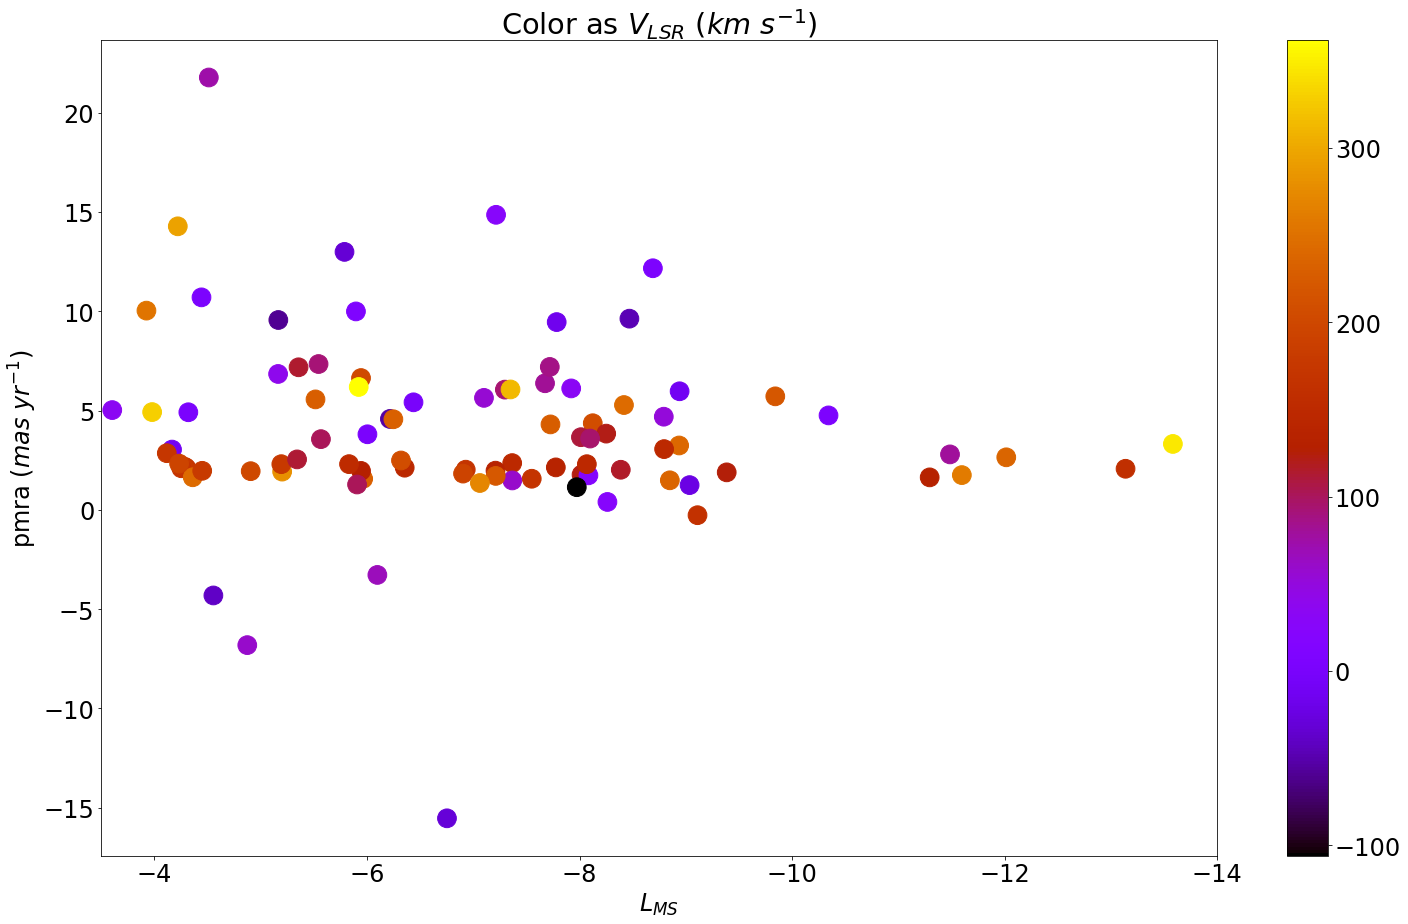

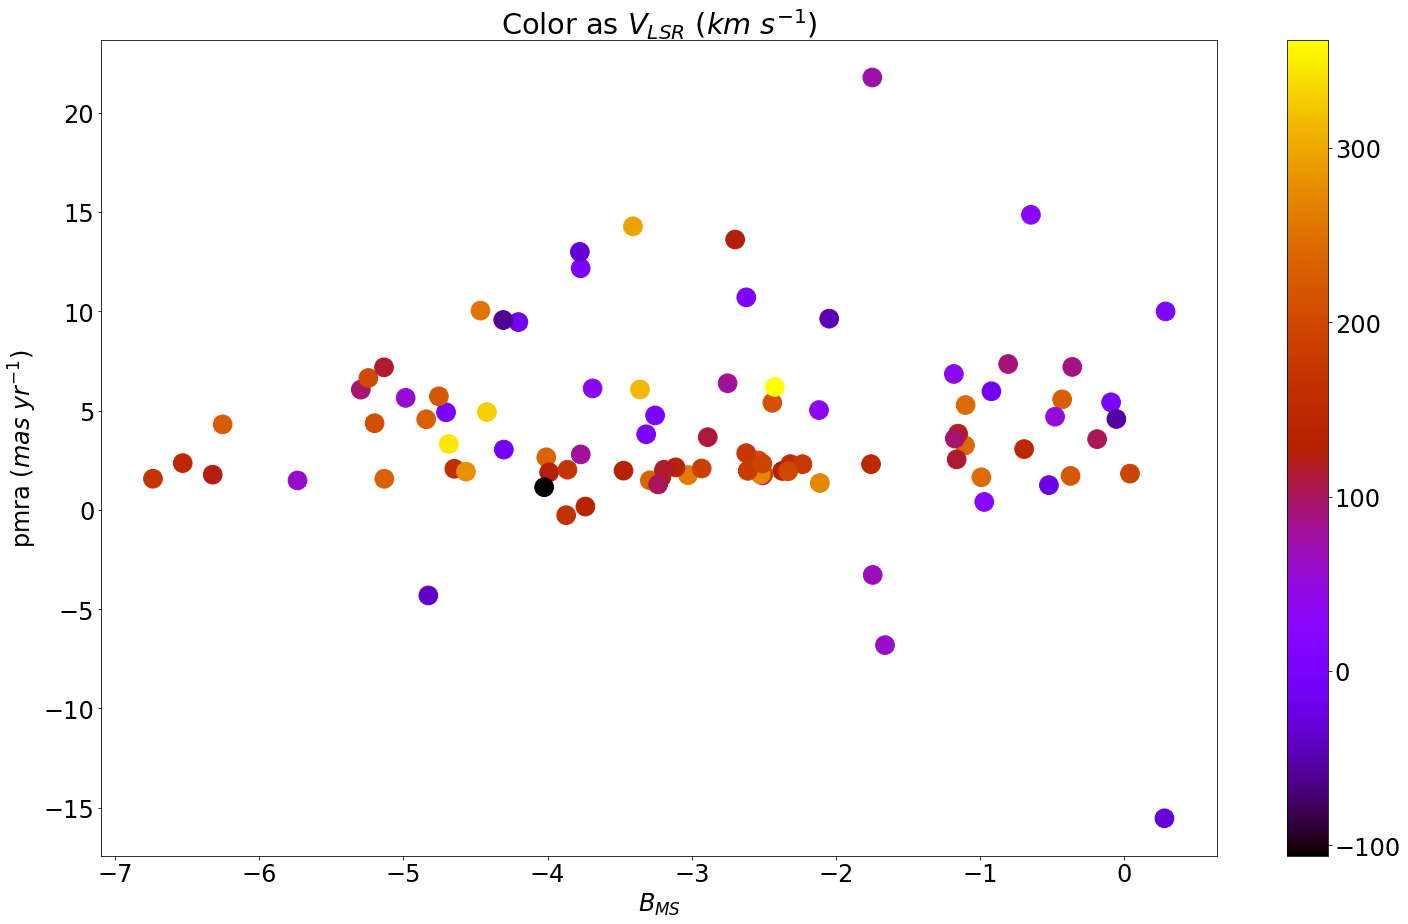

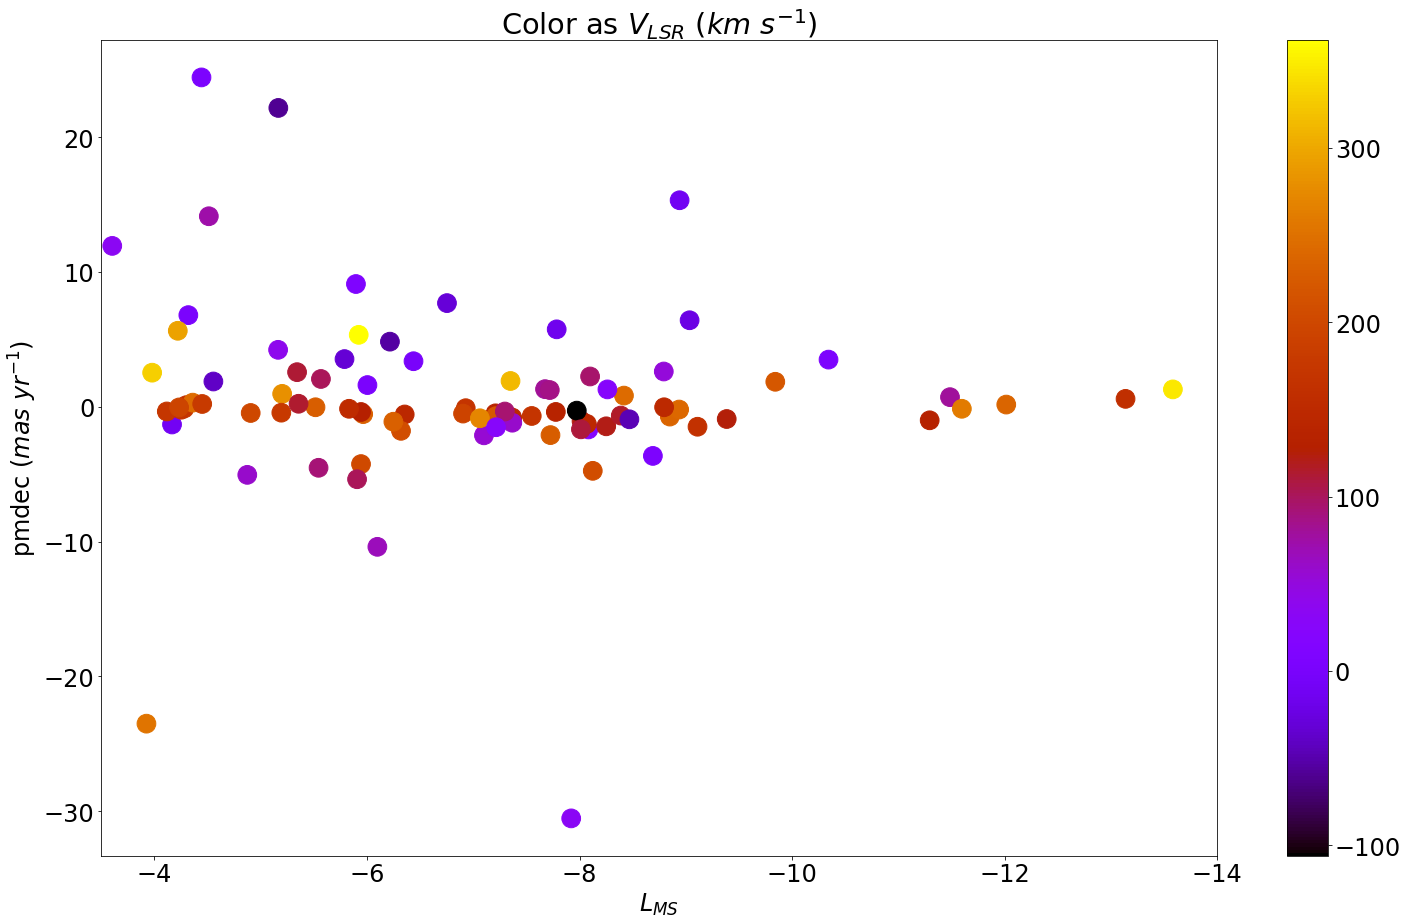

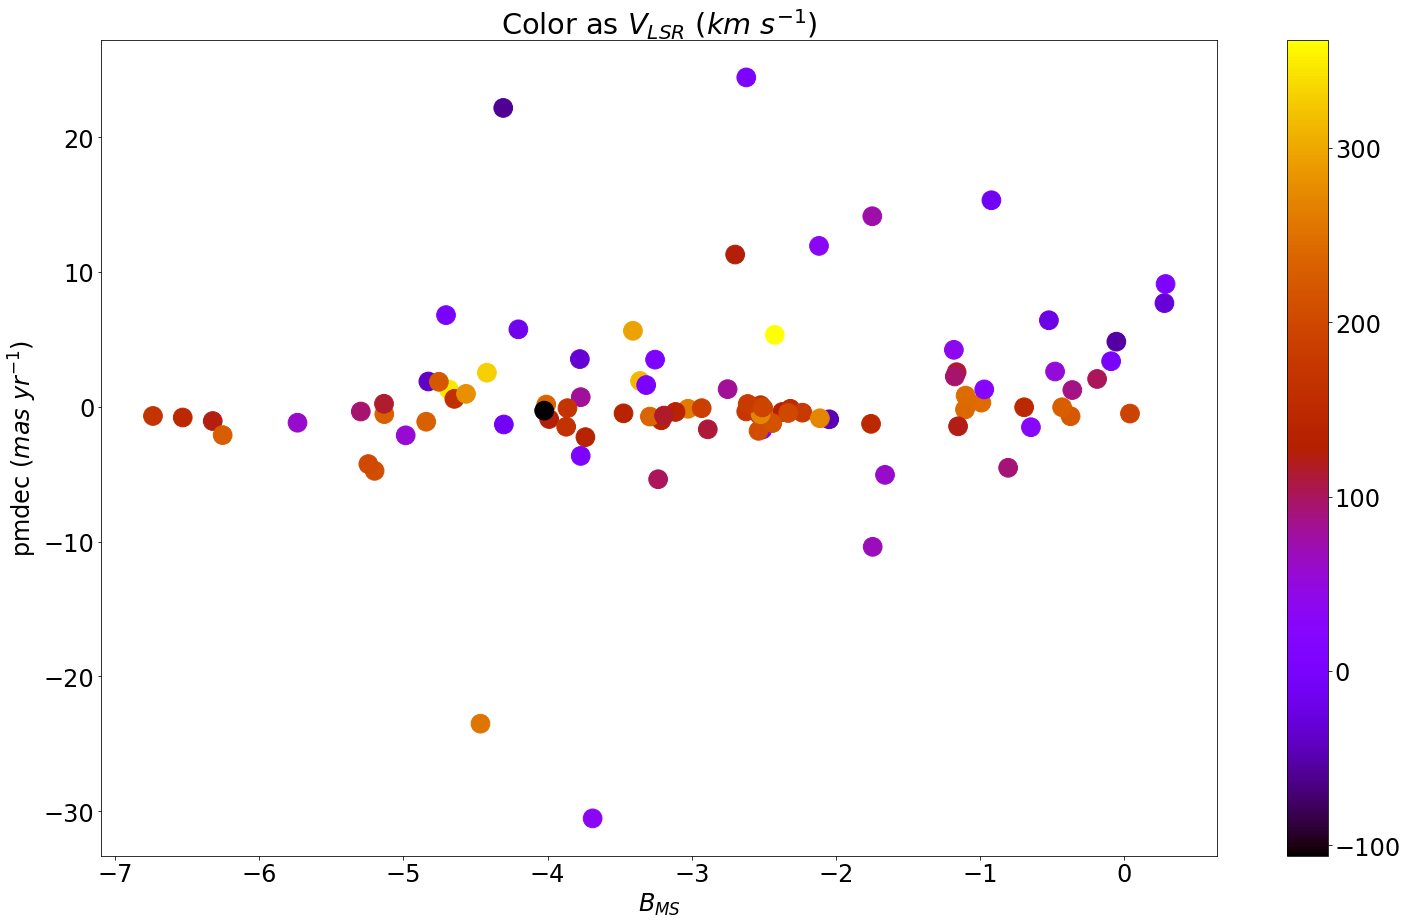

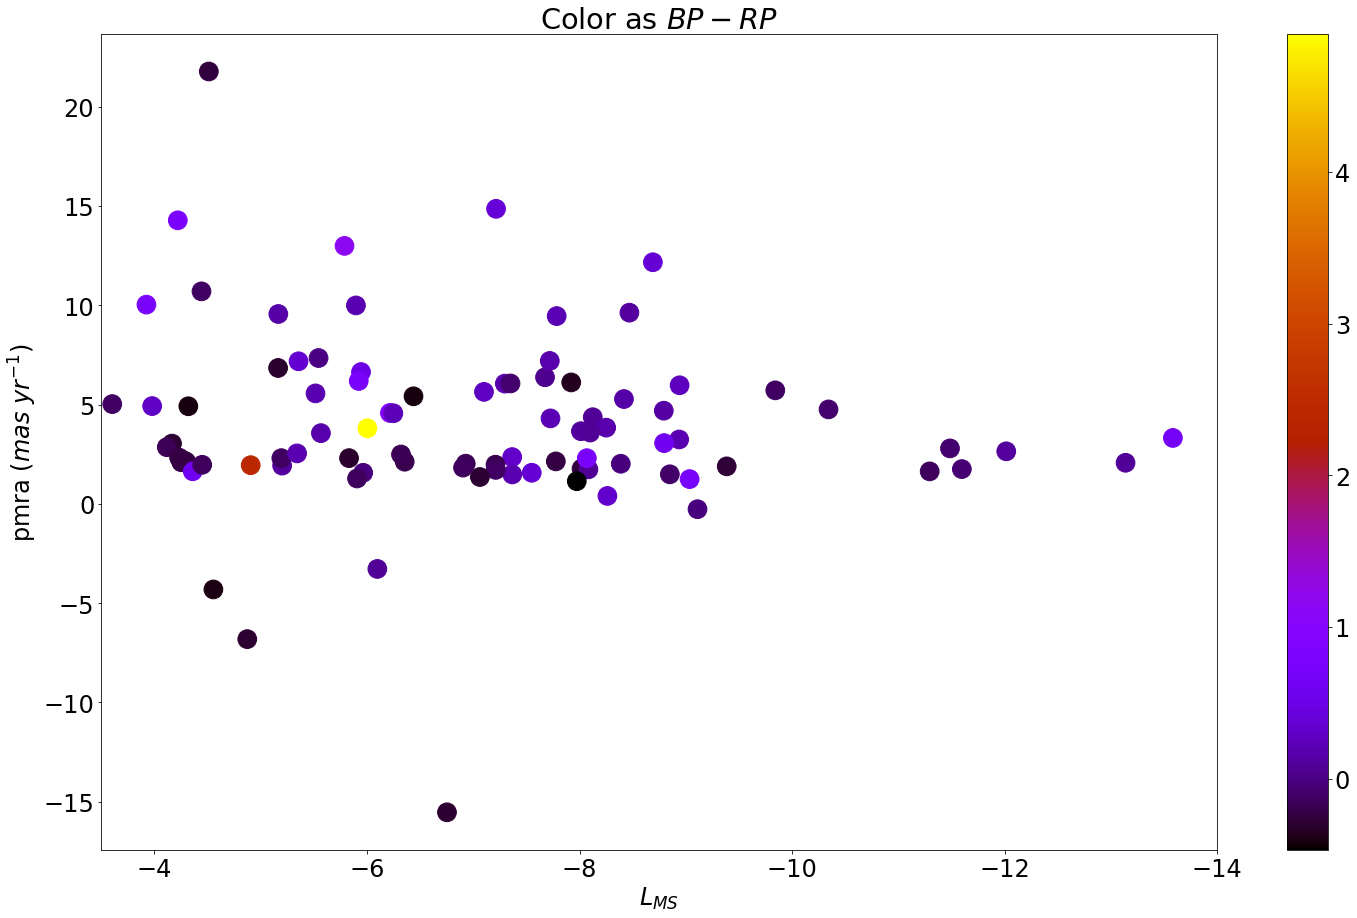

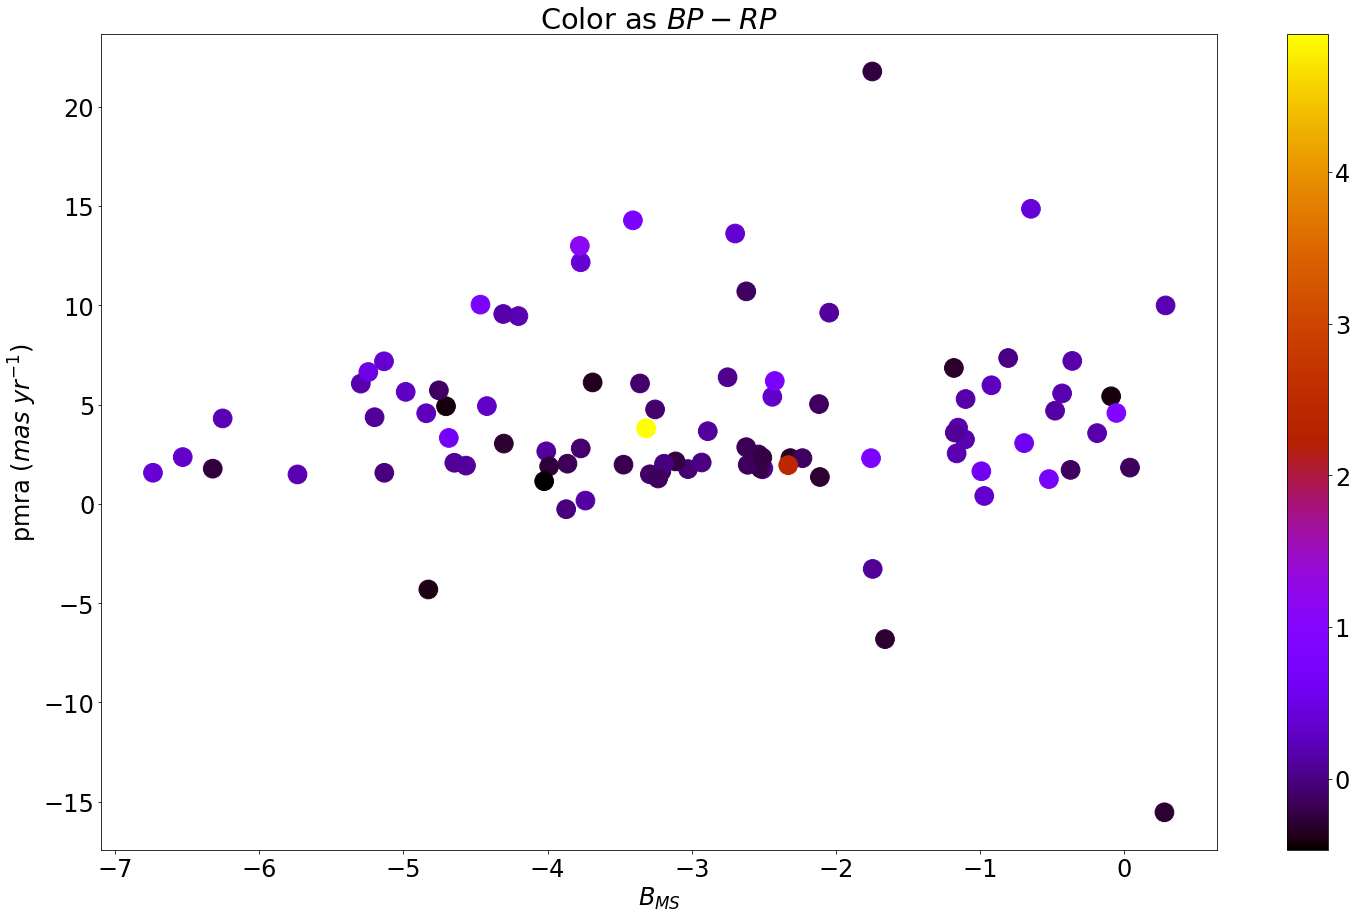

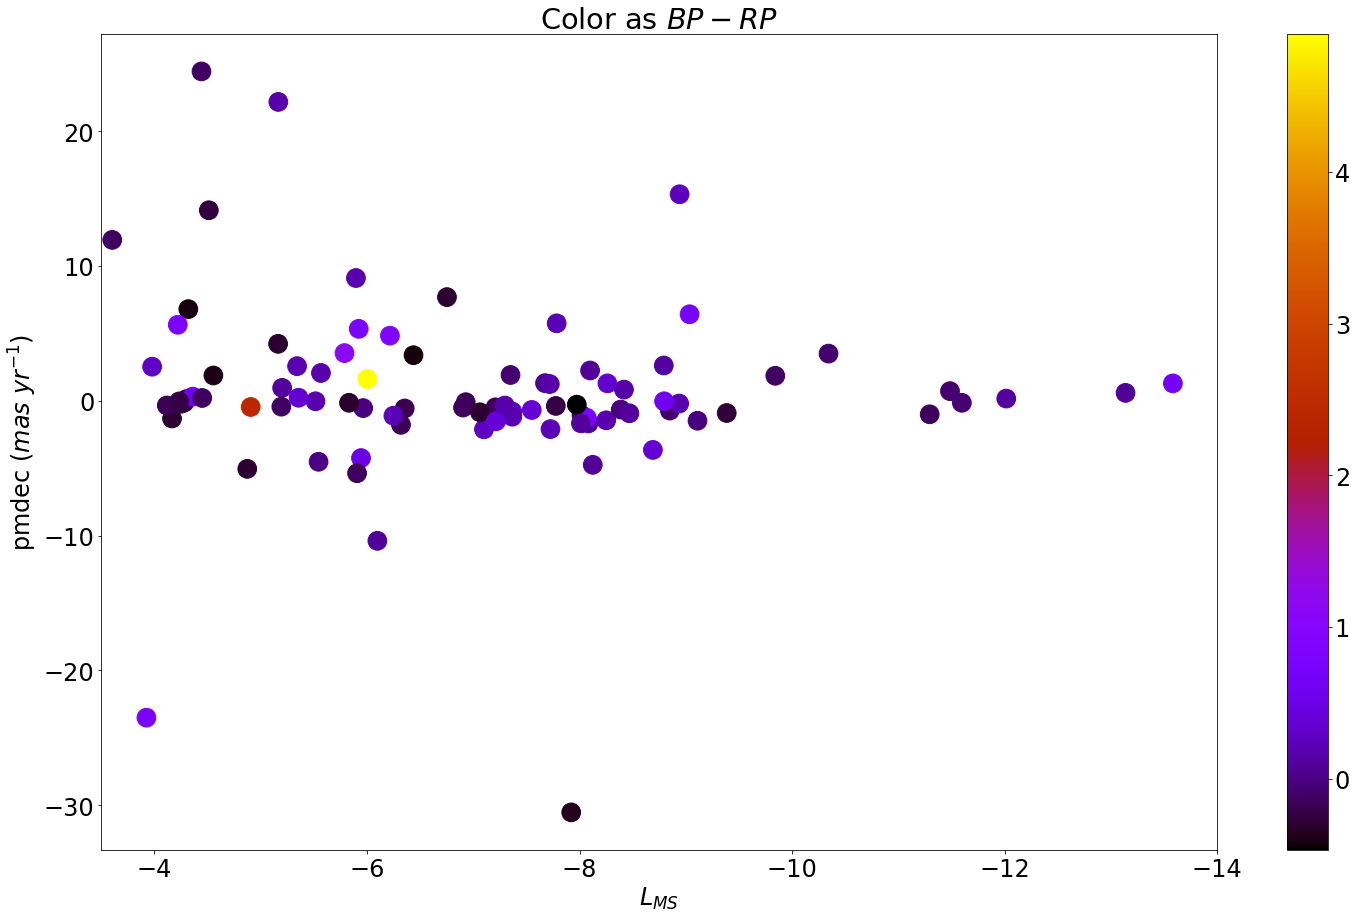

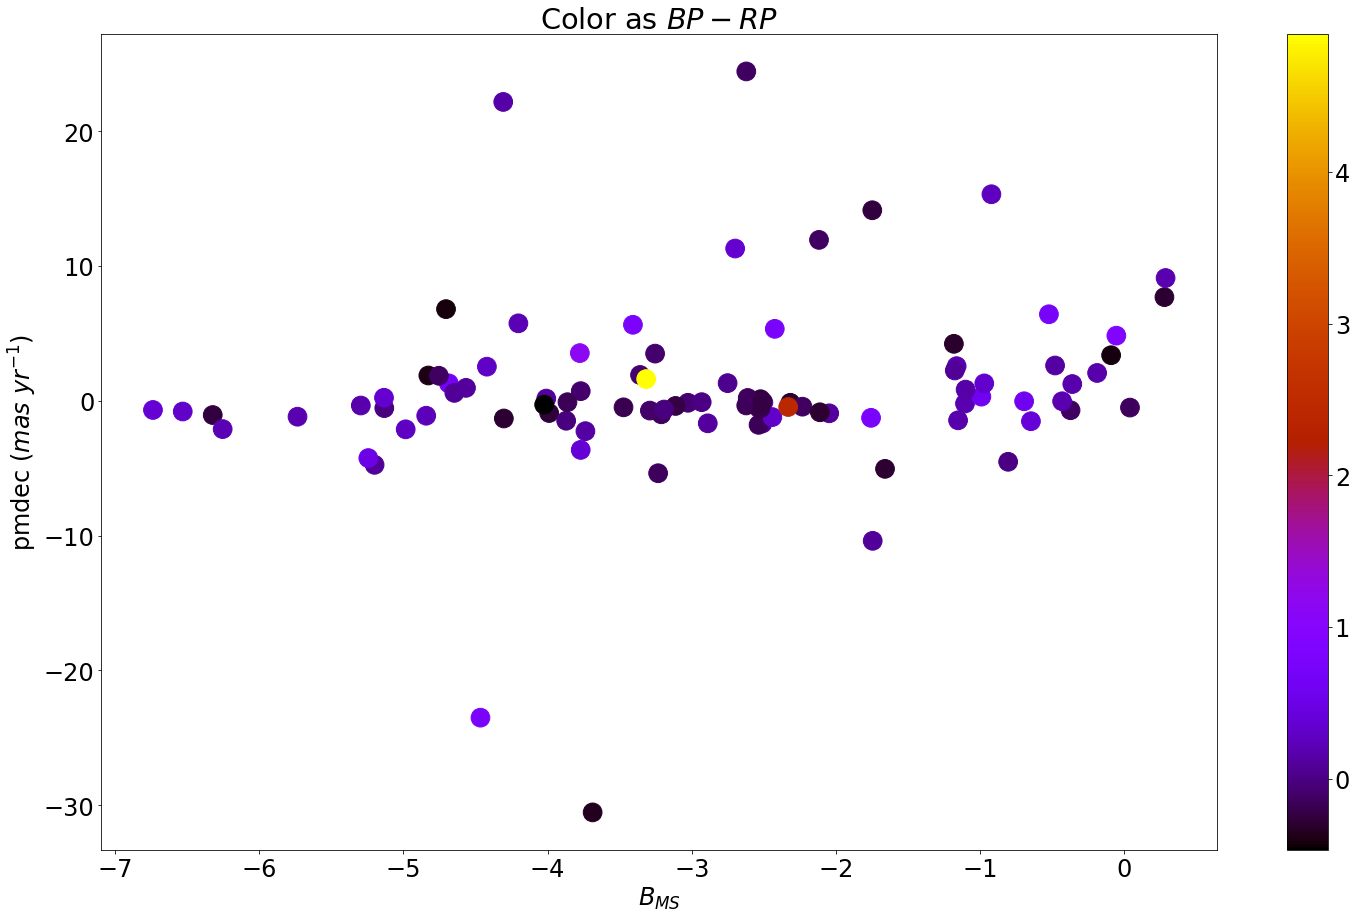

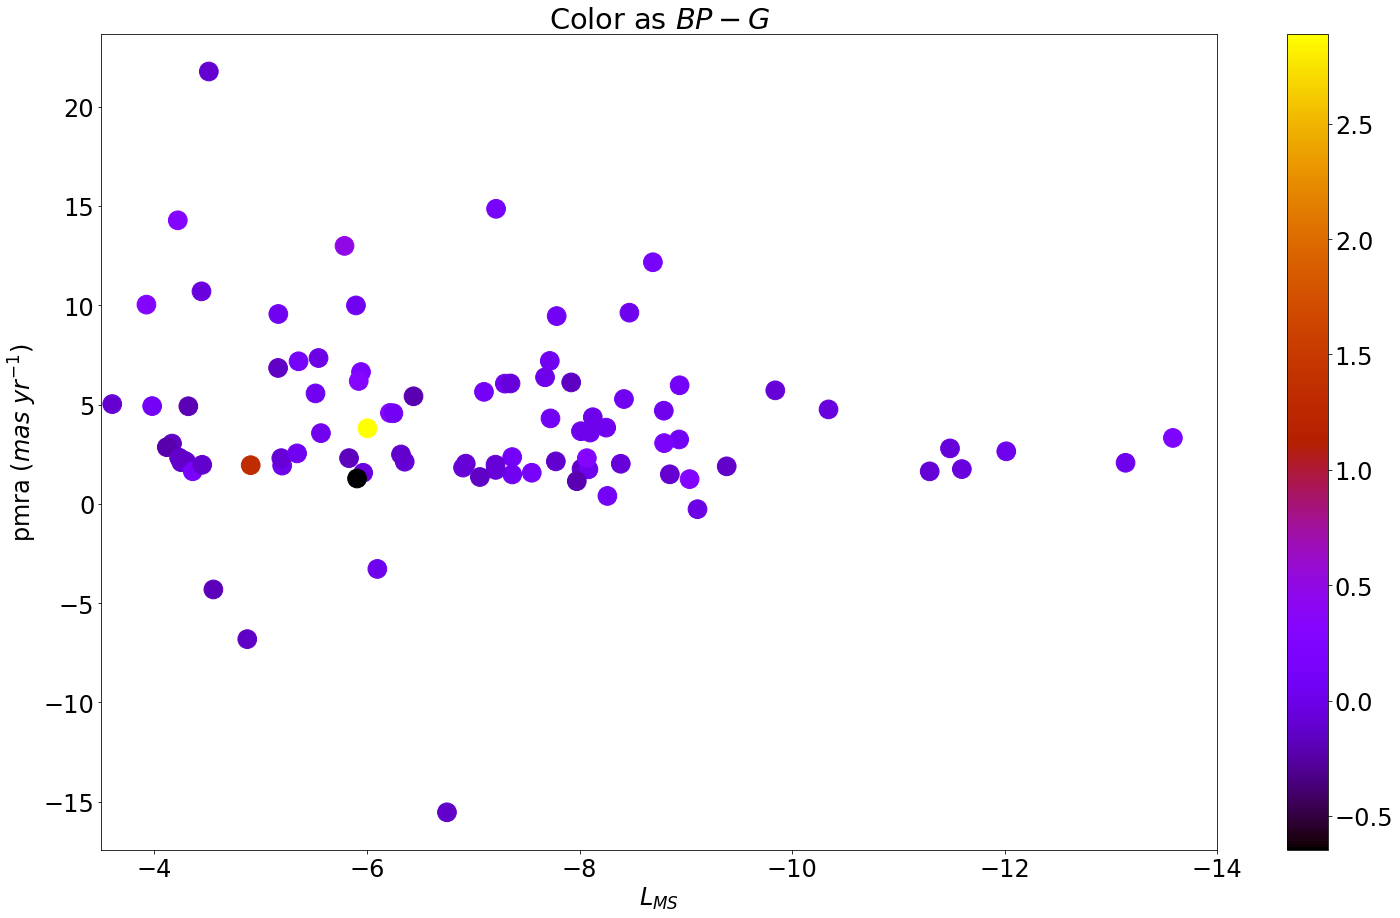

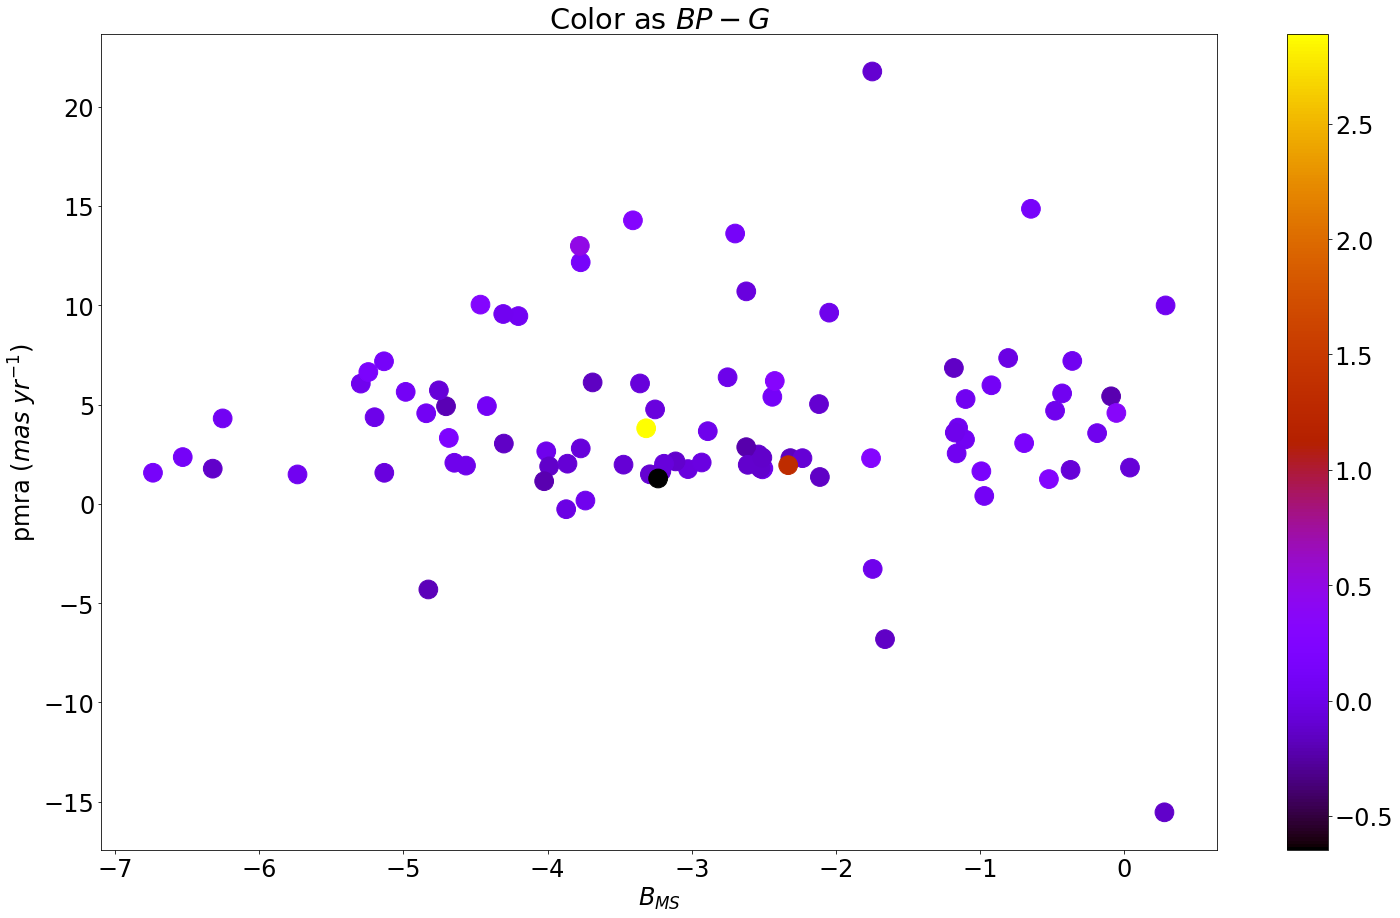

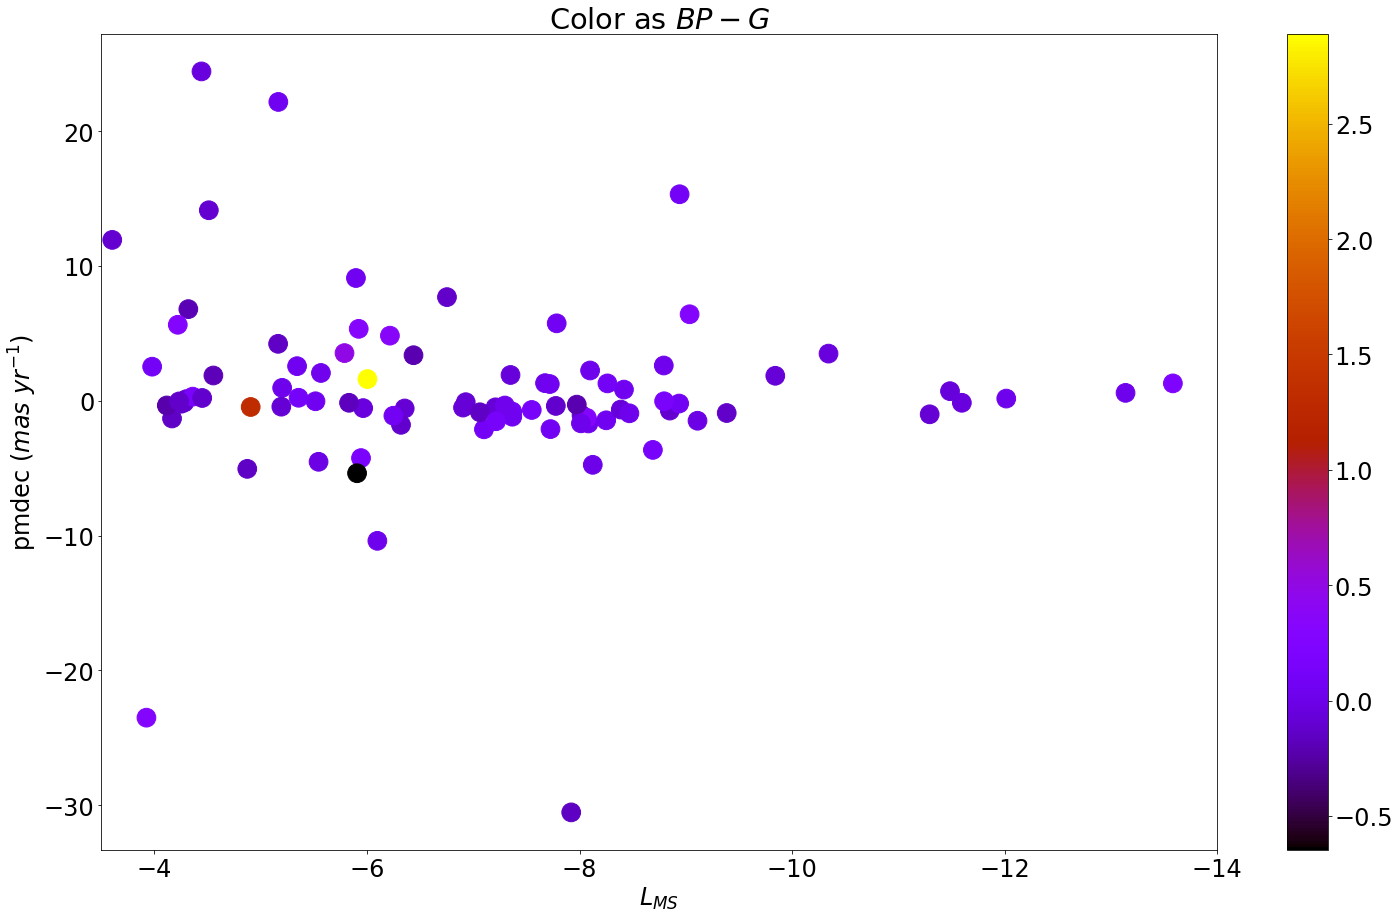

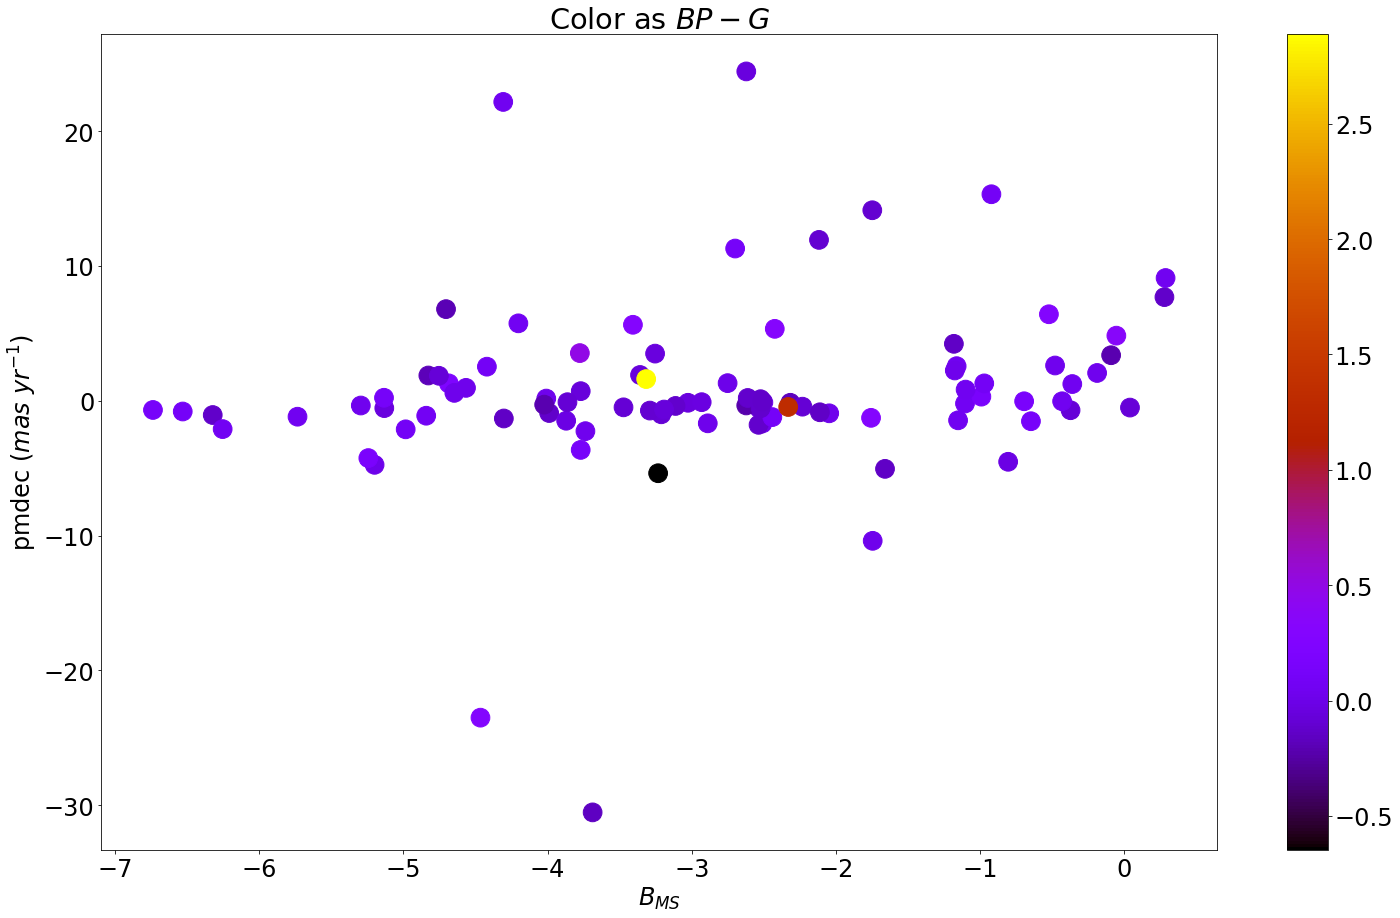

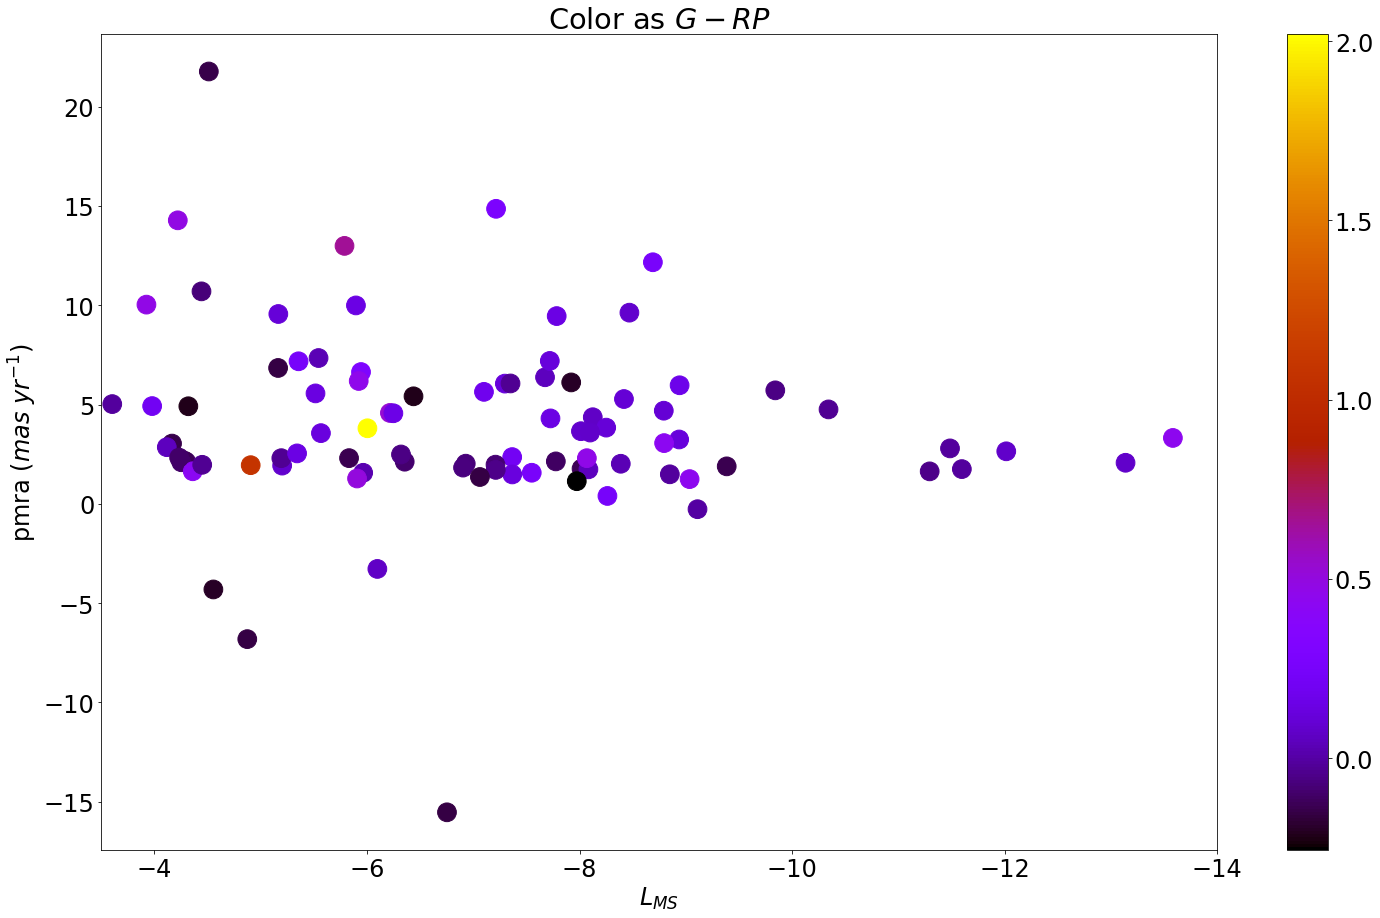

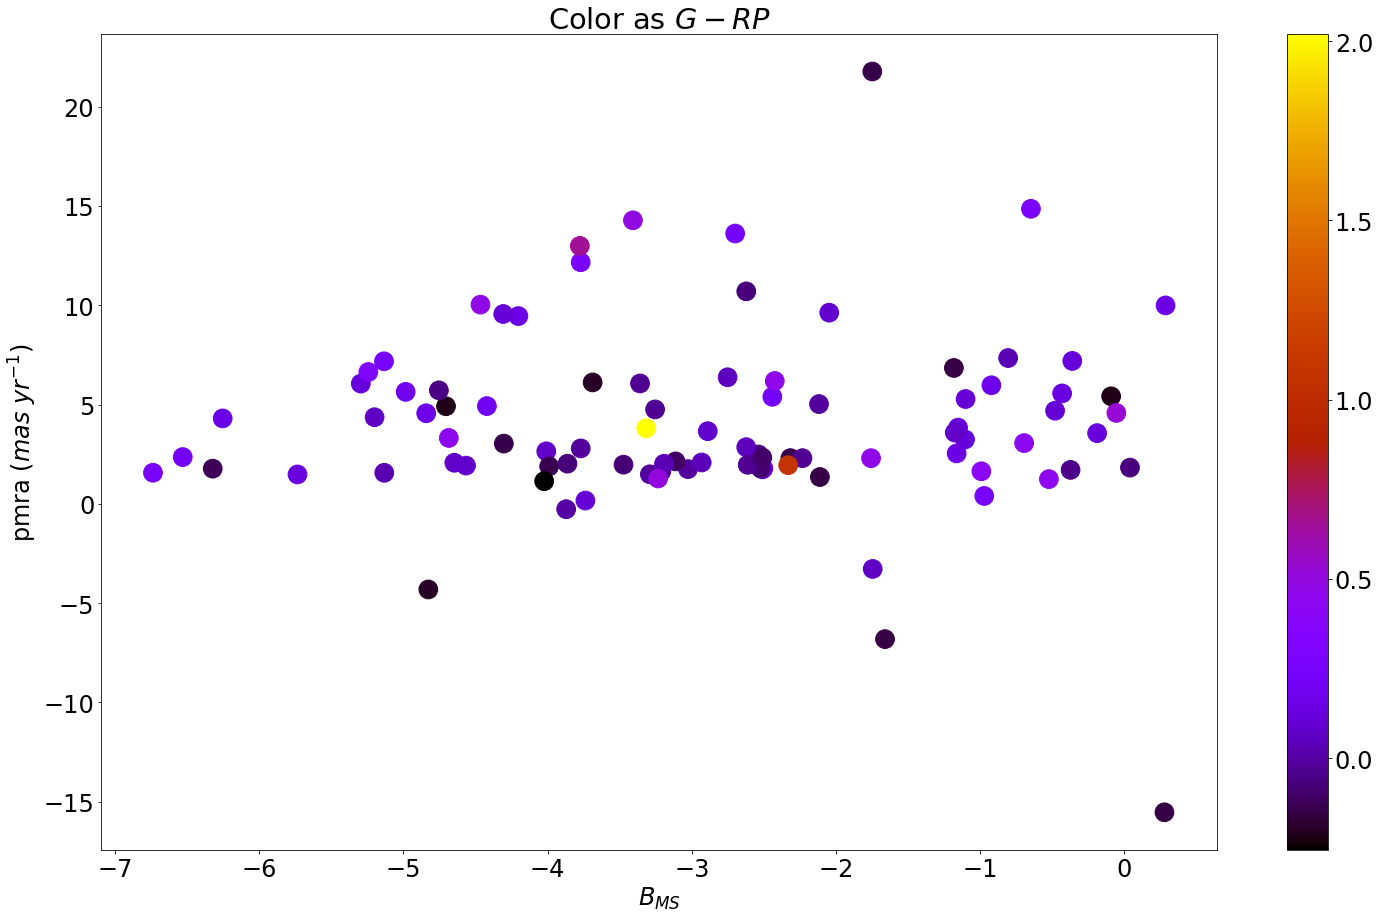

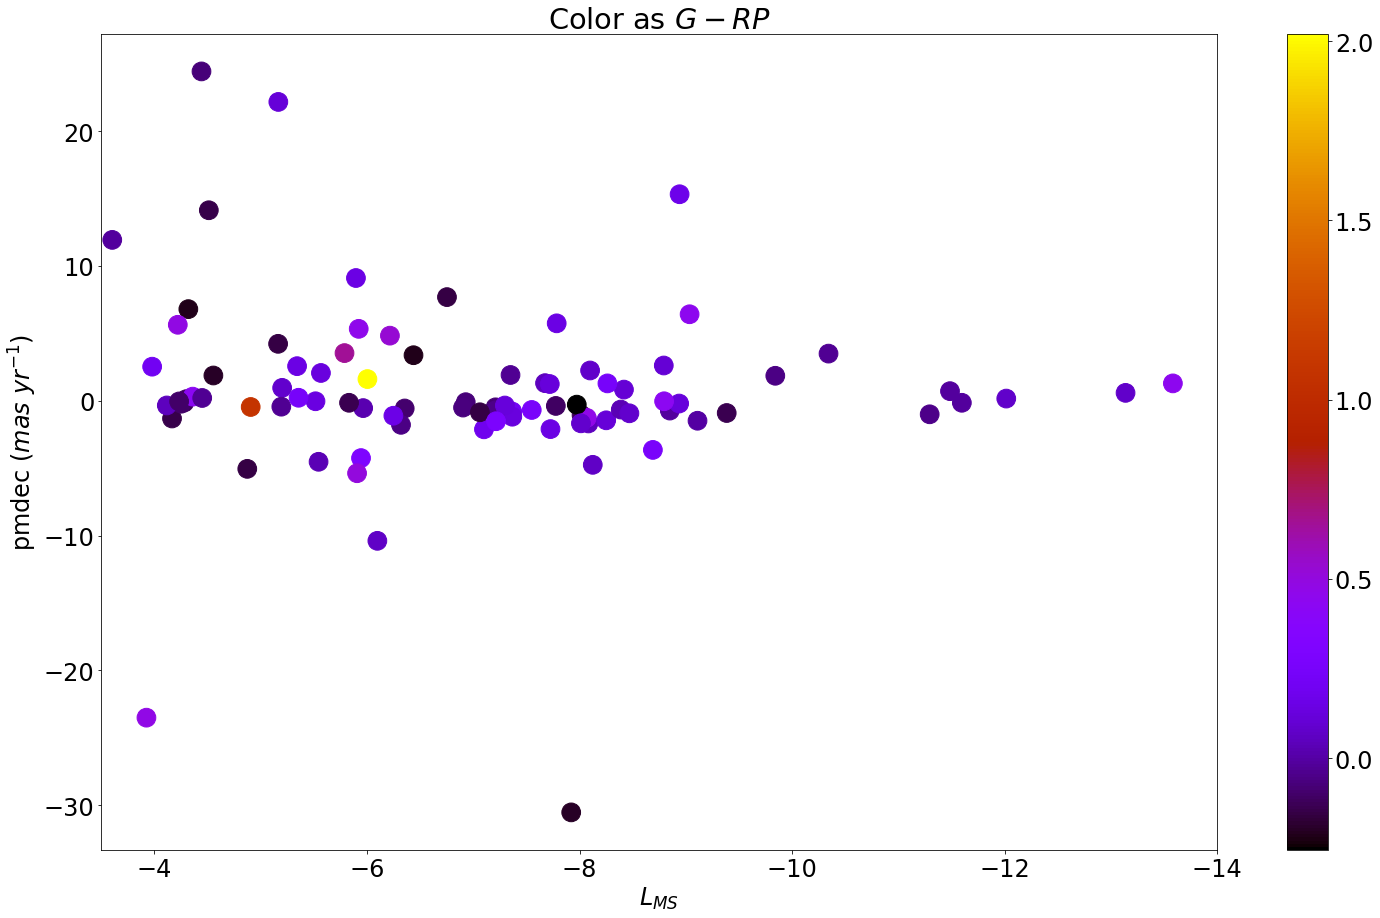

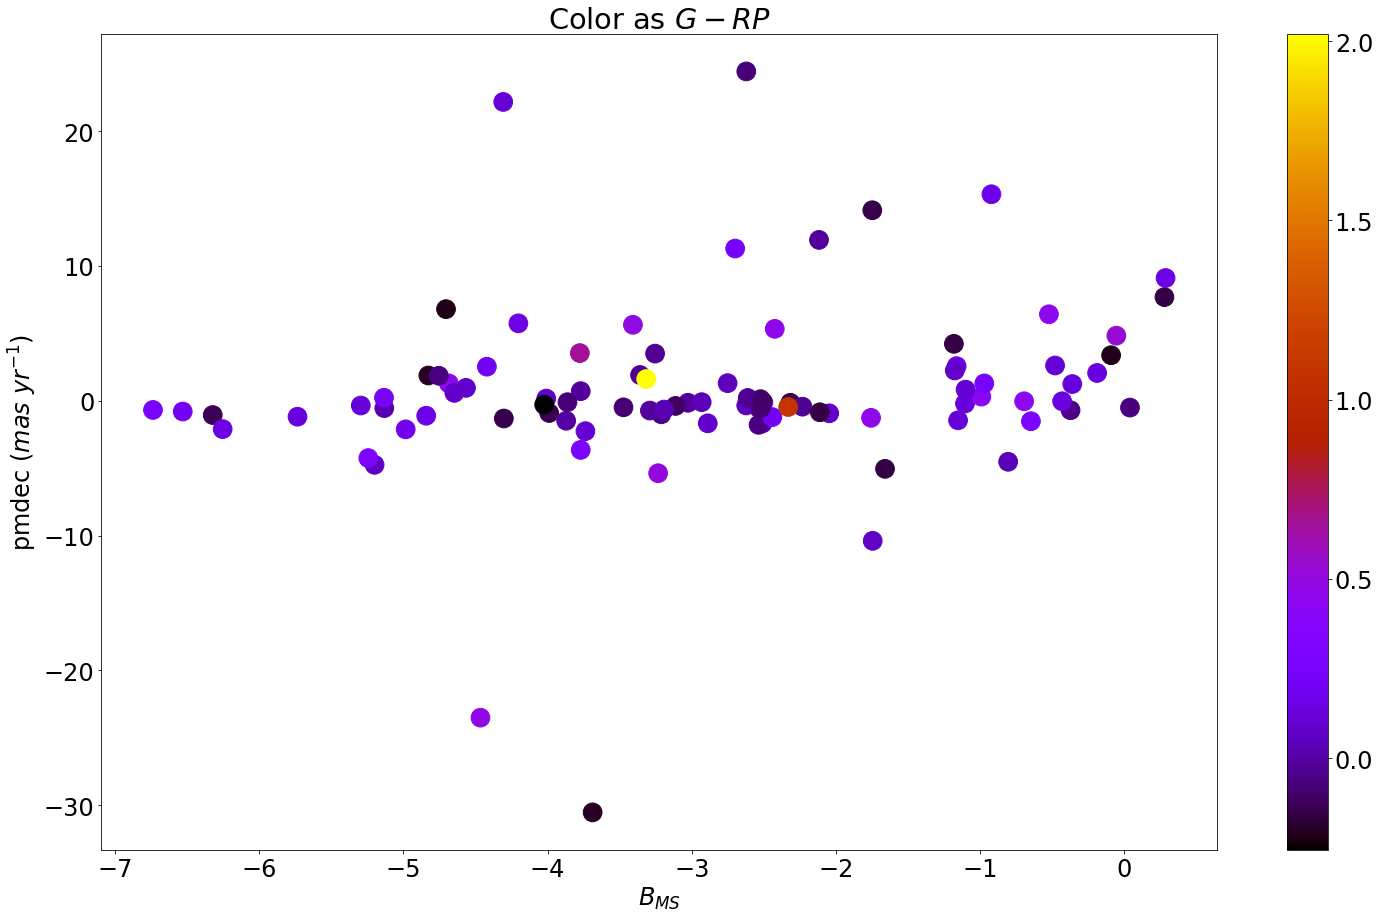

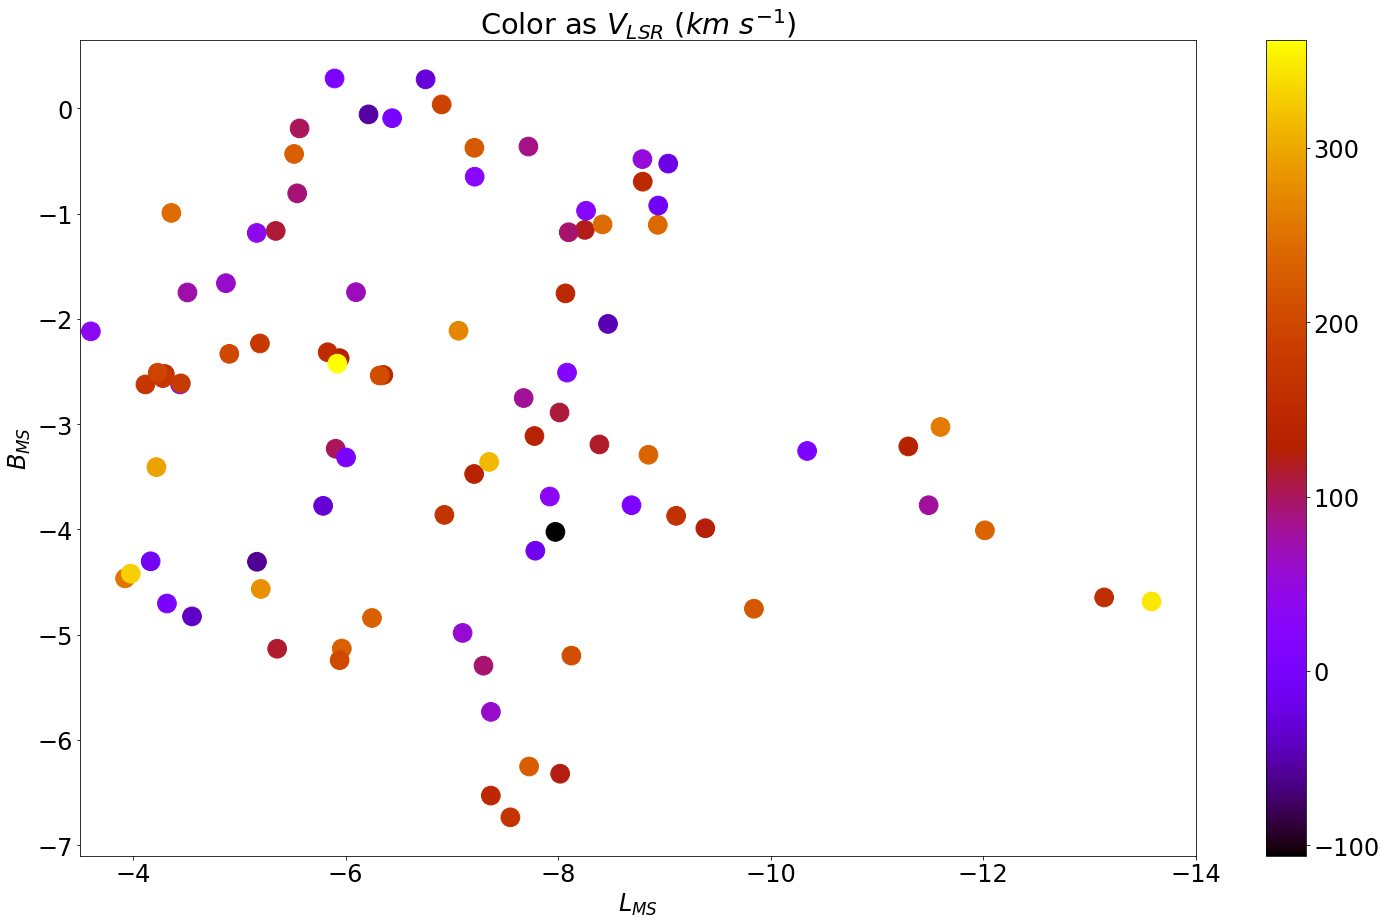

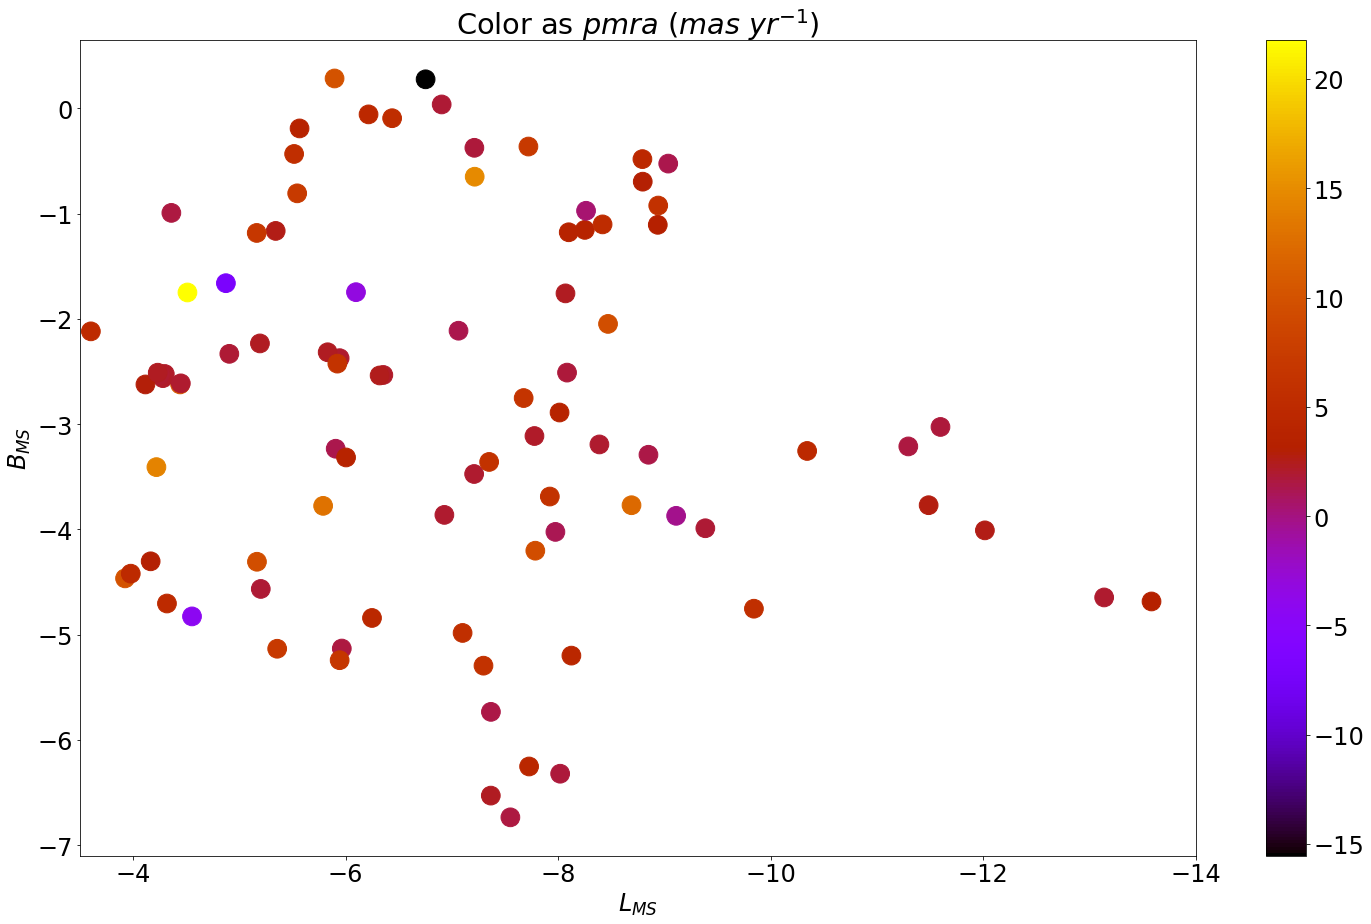

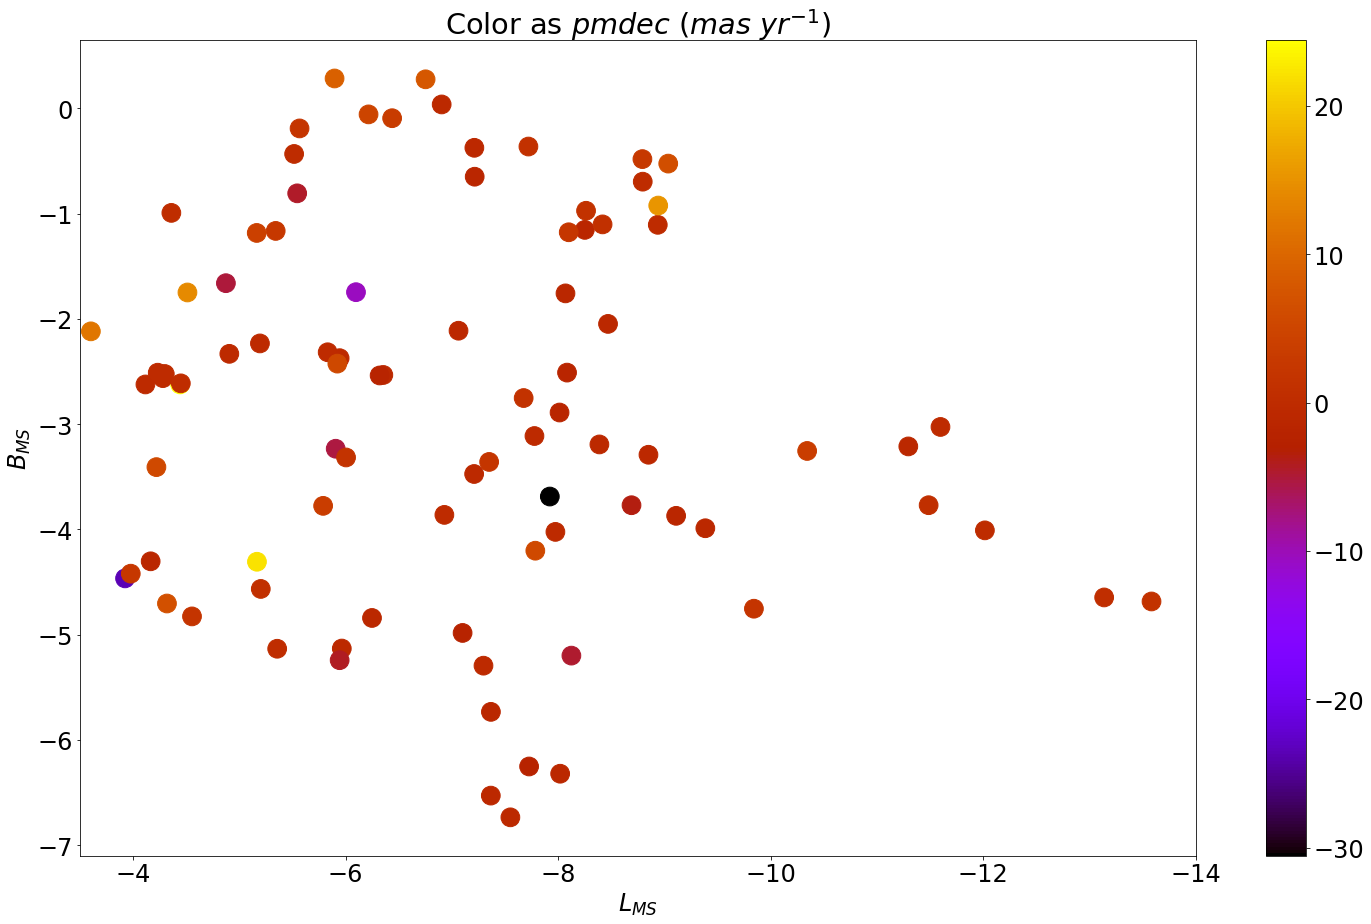

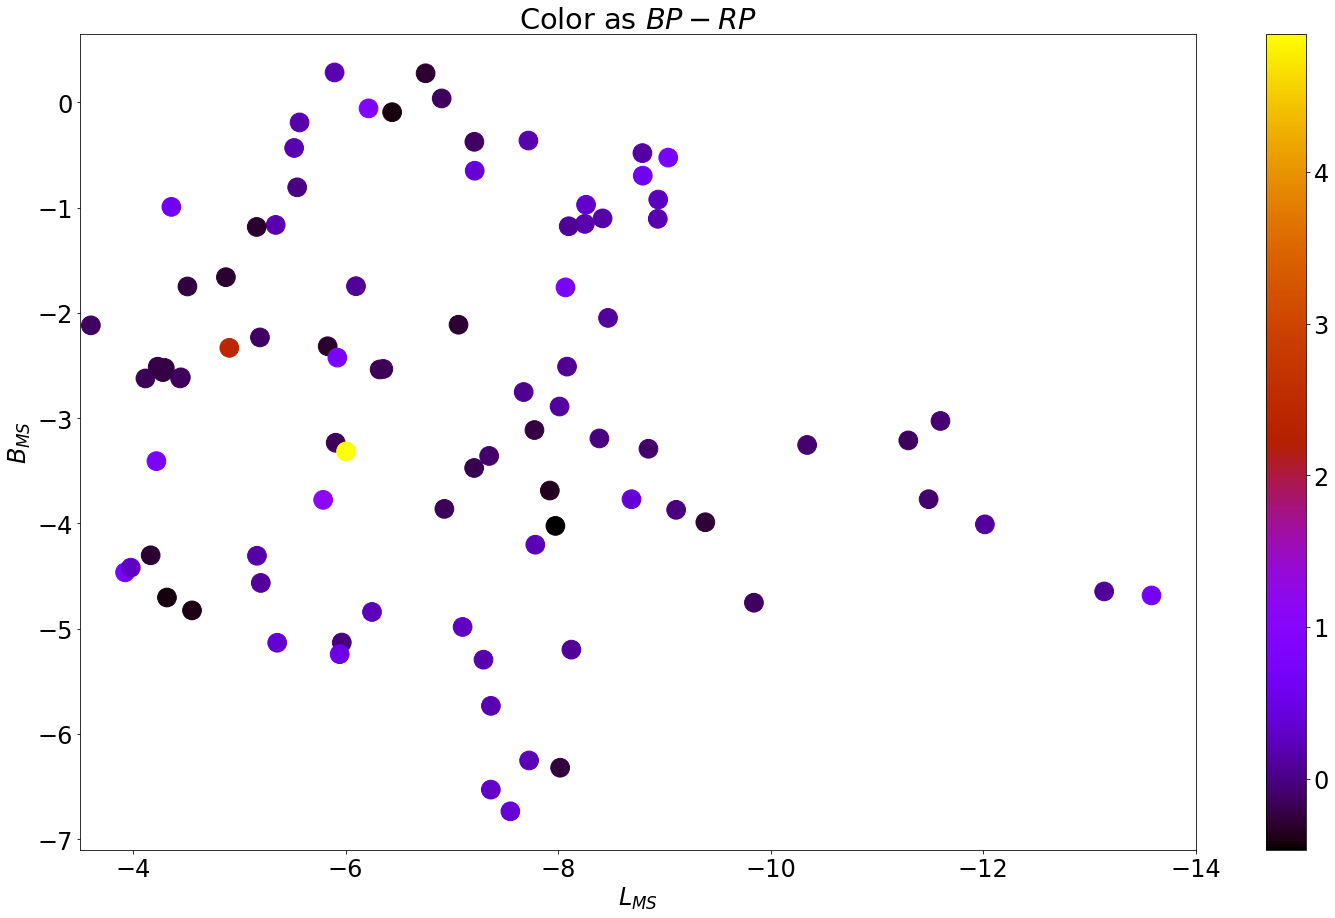

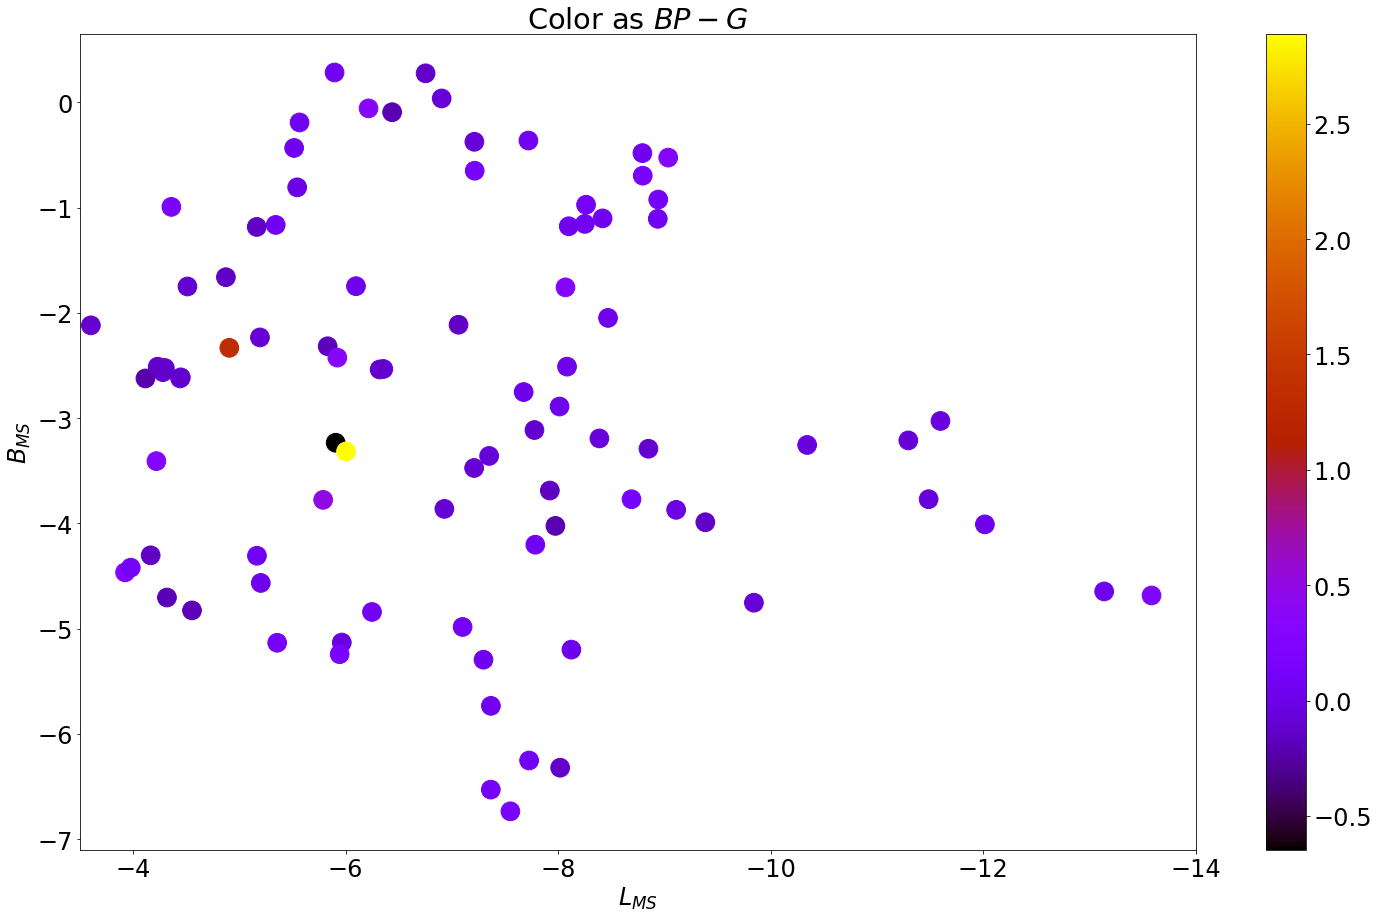

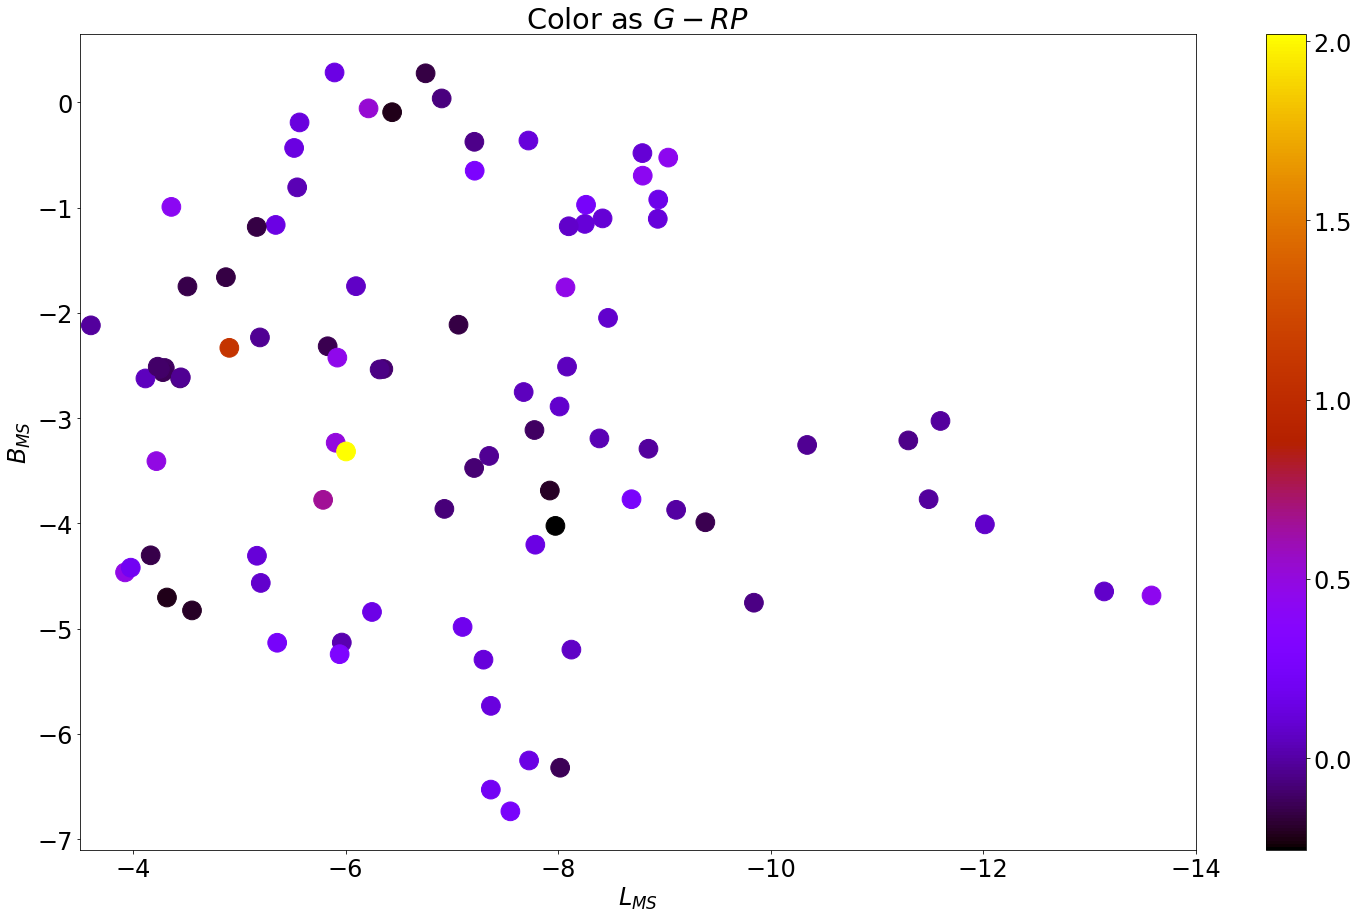

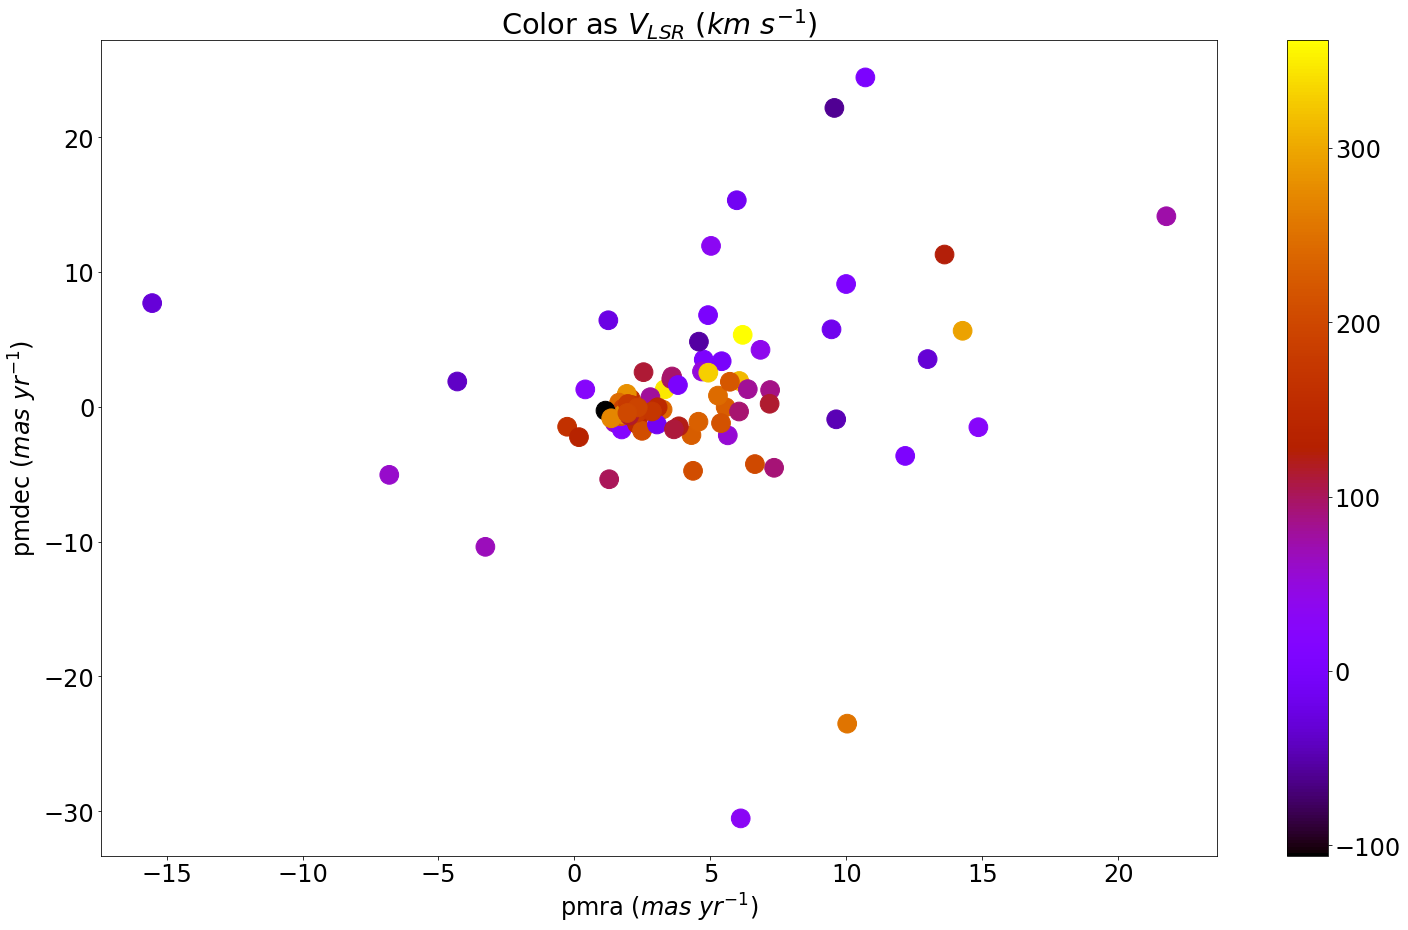

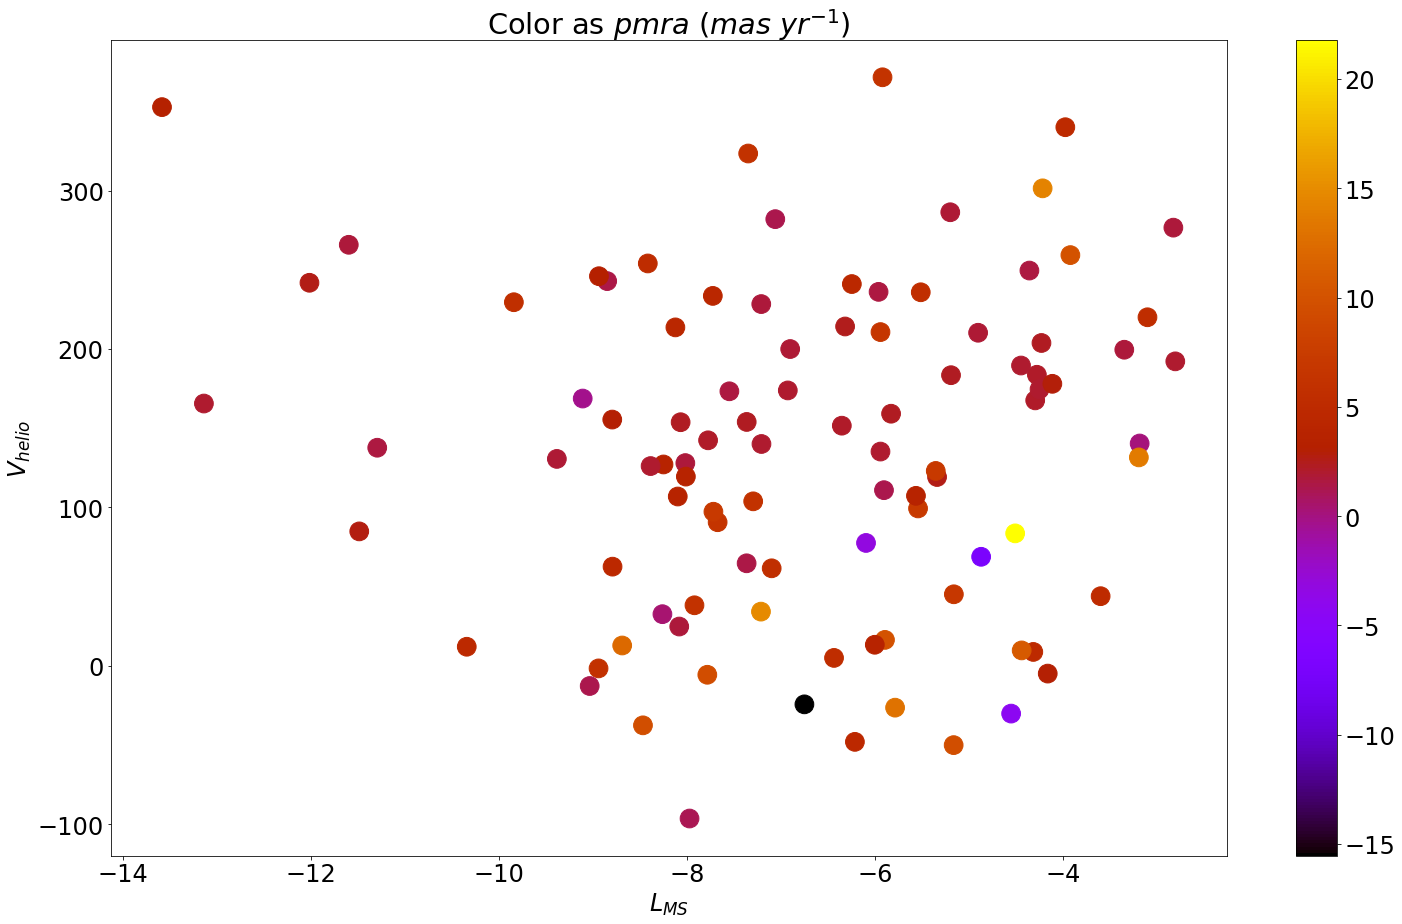

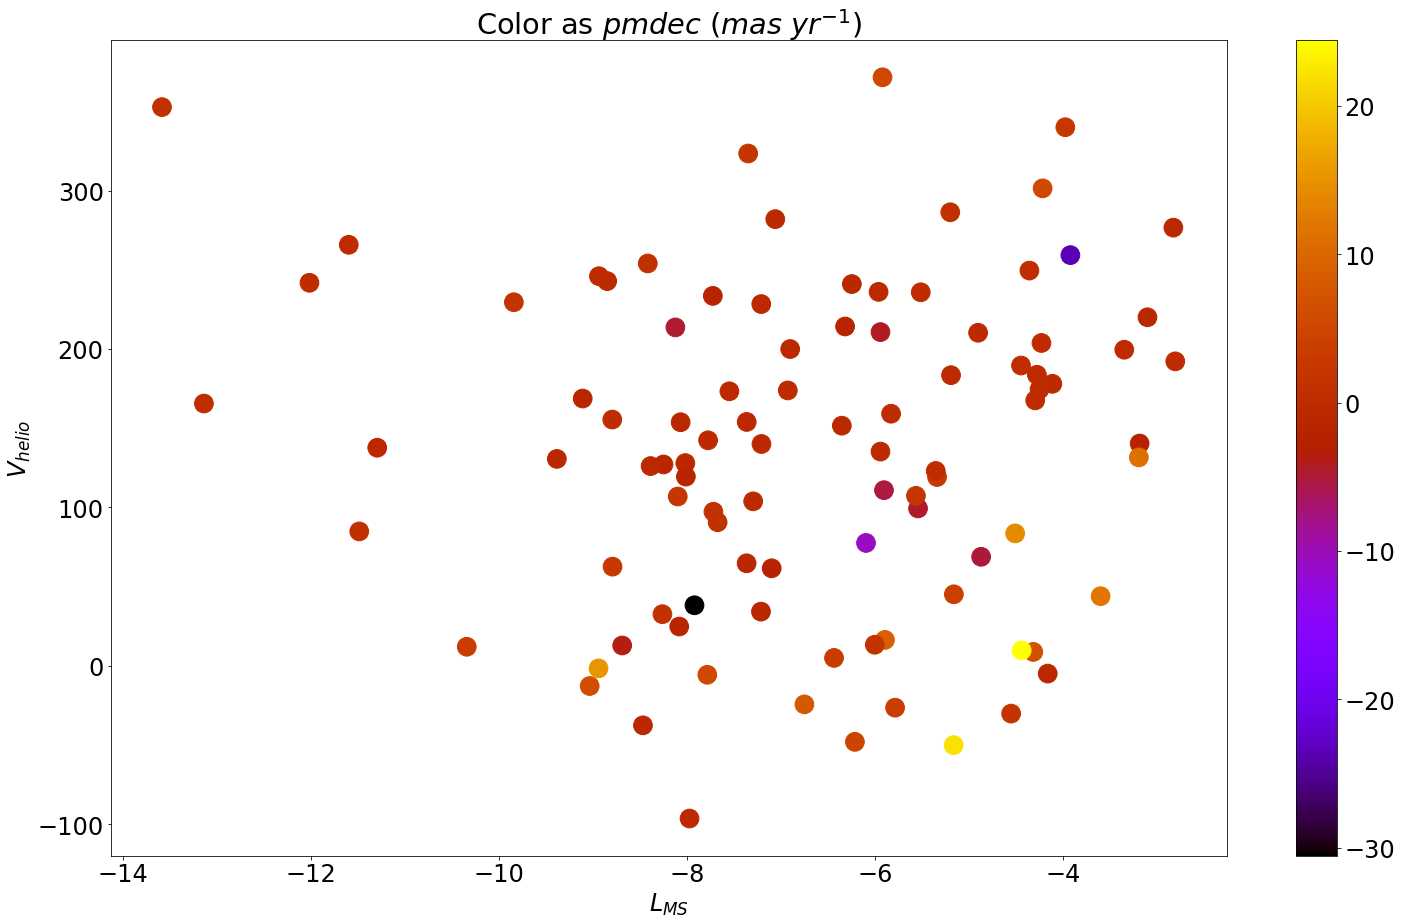

In [100]:
###Data Plots

#pmra, L, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=vlsr,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra ($mas$ $yr^{-1}$)')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmra_L_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=vlsr,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1}$)')
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmra_B_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=vlsr,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmdec_L_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, vlsr
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=vlsr,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmdec_B_vlsr2.pdf', bbox_inches='tight')
plt.show()

#pmra, L, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=BPRP,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmra_L_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=BPRP,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmra_B_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=BPRP,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmdec_L_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, BP-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=BPRP,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('pmdec_B_bprp2.pdf', bbox_inches='tight')
plt.show()

#pmra, L, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=BPG,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmra_L_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=BPG,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmra_B_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=BPG,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmdec_L_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, BP-G
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=BPG,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('pmdec_B_bpg2.pdf', bbox_inches='tight')
plt.show()

#pmra, L, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmra,c=GRP,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmra_L_grp2.pdf', bbox_inches='tight')
plt.show()

#pmra, B, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmra,c=GRP,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmra $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmra_B_grp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, L, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_lg-360,pmdec,c=GRP,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmdec_L_grp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, B, G-RP
plt.figure(figsize = [25,15])
plt.scatter(ms_bg,pmdec,c=GRP,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$B_{MS}$')
plt.ylabel('pmdec $(mas$ $yr^{-1})$')
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('pmdec_B_grp2.pdf', bbox_inches='tight')
plt.show()

#positon, vlsr
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=vlsr,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('position_vlsr2.pdf', bbox_inches='tight')
plt.show()

#position, pmra
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=pmra,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $pmra$ $(mas$ $yr^{-1})$')
plt.savefig('positon_pmra2.pdf', bbox_inches='tight')
plt.show()

#position, pmdec
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=pmdec,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $pmdec$ $(mas$ $yr^{-1})$')
plt.savefig('position_pmdec2.pdf', bbox_inches='tight')
plt.show()

#position, BP-RP
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=BPRP,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-RP$')
plt.savefig('position_bprp2.pdf', bbox_inches='tight')
plt.show()

#position, BP-G
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=BPG,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $BP-G$')
plt.savefig('position_grp2.pdf', bbox_inches='tight')
plt.show()

#position, G-RP
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,ms_bg,c=GRP,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$B_{MS}$')
plt.xlim(-3.5,-14)
plt.colorbar()
plt.title('Color as $G-RP$')
plt.savefig('position_grp2.pdf', bbox_inches='tight')
plt.show()

#pmdec, pmra, vlsr
plt.figure(figsize=[25,15])
plt.scatter(pmra,pmdec,c=vlsr,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('pmra $(mas$ $yr^{-1}$)')
plt.ylabel('pmdec $(mas$ $yr^{-1}$)')
plt.colorbar()
plt.title('Color as $V_{LSR}$ $(km$ $s^{-1})$')
plt.savefig('pmdec_pmra_vlsr2.pdf',bbox_inches='tight')
plt.show()

#vhelio, L, pmra
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,vhelio,c=pmra,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$V_{helio}$')
plt.colorbar()
plt.title('Color as $pmra$ $(mas$ $yr^{-1})$')
plt.savefig('vhelio_L_pmra2.pdf',bbox_inches='tight')
plt.show()

#vhelio, L, pmdec
plt.figure(figsize=[25,15])
plt.scatter(ms_lg-360,vhelio,c=pmdec,s=350,cmap=plt.cm.get_cmap('gnuplot'))
plt.xlabel('$L_{MS}$')
plt.ylabel('$V_{helio}$')
plt.colorbar()
plt.title('Color as $pmdec$ $(mas$ $yr^{-1})$')
plt.savefig('vhelio_L_pmdec2.pdf',bbox_inches='tight')
plt.show()